In [3]:
import pandas as pd
import networkx as nx
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import TransformerConv
from torch_geometric.nn import GATConv

from torch_geometric.nn import GCNConv
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.utils import from_networkx
from sklearn.metrics import confusion_matrix, classification_report
import os
from tqdm import tqdm
import joblib
import matplotlib.pyplot as plt
import glob
import time

from torch.nn import LSTM


import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc


In [4]:
data_clean_folder = "stage3_data_cleaning/v2"
folder_path = data_clean_folder
xlsx_files = glob.glob(os.path.join(folder_path, '*.xlsx'))
xlsx_files

['stage3_data_cleaning/v2\\type10_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type1_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type2_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type3_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type4_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type5_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type6_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type7_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type8_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type9_label_merged_final_decoded_clean3.xlsx']

In [5]:
def calculate_optimized_pagerank(G, damping_factor=0.7):
    N = len(G)
    pagerank = {node: 1 / N for node in G}
    for _ in range(100):  # Iterate 100 times for convergence
        new_pagerank = {}
        for node in G:
            rank_sum = 0
            for neighbor in G.predecessors(node):
                weight_sum = sum([G[neighbor][succ]['weight'] for succ in G.successors(neighbor)])
                rank_sum += pagerank[neighbor] * (G[neighbor][node]['weight'] / weight_sum)
            new_pagerank[node] = (1 - damping_factor) / N + damping_factor * rank_sum
        pagerank = new_pagerank
    nx.set_node_attributes(G, pagerank, 'pagerank')
    return G

def create_graph_density(window_df, past_data):
    G = nx.DiGraph()
    index_tracker = {}
    
    for i in range(len(window_df) - 1):
        node1 = window_df.iloc[i]['can_id']
        node2 = window_df.iloc[i + 1]['can_id']
        timestamp_diff = window_df.iloc[i + 1]['timestamp'] - window_df.iloc[i]['timestamp']
        label = window_df.iloc[i]['label']
        transfer_id1 = window_df.iloc[i]['transfer_ID']
        transfer_id2 = window_df.iloc[i + 1]['transfer_ID']
        
        if node1 != node2 or transfer_id1 != transfer_id2:  # Allow self-loops only if transfer_IDs are different
            if G.has_edge(node1, node2):
                G[node1][node2]['weight'] += timestamp_diff
            else:
                G.add_edge(node1, node2, weight=timestamp_diff)
        
        # if node1 not in index_tracker:
        #     index_tracker[node1] = set()
        # index_tracker[node1].add((i, label))
        
        # if node2 not in index_tracker:
        #     index_tracker[node2] = set()
        # index_tracker[node2].add((i, label))

        
        if node1 not in index_tracker:
            index_tracker[node1] = []
        index_tracker[node1].append((i, label))
        
        
        if node2 not in index_tracker:
            index_tracker[node2] = []
        index_tracker[node2].append((i, label))

    
    # Convert sets to sorted lists to ensure consistent ordering
    index_tracker = {k: sorted(list(v)) for k, v in index_tracker.items()}
    
    # Calculate optimized PageRank
    G = calculate_optimized_pagerank(G)
    
    # Calculate density for each node based on past data
    density = calculate_density(window_df, past_data)
    
    for node in G.nodes:
        G.nodes[node]['density'] = density.get(node, 0.0)

    indegree = G.in_degree()
    outdegree = G.out_degree()
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    clustering_coefficient = nx.clustering(G)

    for node in G.nodes:
        G.nodes[node]['indegree'] = indegree[node]
        G.nodes[node]['outdegree'] = outdegree[node]
        G.nodes[node]['degree_centrality'] = degree_centrality[node]
        G.nodes[node]['betweenness_centrality'] = betweenness_centrality[node]
        G.nodes[node]['closeness_centrality'] = closeness_centrality[node]
        G.nodes[node]['clustering_coefficient'] = clustering_coefficient[node]
    
    return G, index_tracker

def calculate_density(window_df, past_data):
    density = {}
    combined_data = pd.concat([past_data, window_df])
    for node in window_df['can_id'].unique():
        node_count = combined_data[combined_data['can_id'] == node].shape[0]
        density[node] = round(node_count / combined_data.shape[0],3)
    return density



def visualize_graph_density(G, window_index,visualization_dir):
    pos = nx.spring_layout(G)
    pagerank = nx.get_node_attributes(G, 'pagerank')
    density = nx.get_node_attributes(G, 'density')
    
    # Ensure all nodes have a pagerank value, set default if missing
    for node in G.nodes():
        if node not in pagerank:
            pagerank[node] = 0.0  # Default PageRank value
    
    labels = {node: f'{node}\nPR: {pagerank[node]:.2f}\nDensity: {density[node]}' for node in G.nodes()}
    
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, labels=labels, node_size=7000, node_color='skyblue', font_size=10, edge_color='gray')
    plt.title(f"Graph for Window {window_index}")
    output_path = os.path.join(visualization_dir, f'graph_window_with_density_{window_index}.png')
    plt.savefig(output_path)
    plt.close()





def preprocess_data_density(data,output_dir,visualization_dir,window_size=100, past_window_size=150):
    pyg_data_list = []
    past_data = pd.DataFrame()  # Initialize past data
    
    for window_start in tqdm(range(0, len(data), window_size)):
        window_end = min(window_start + window_size, len(data))
        window_data = data.iloc[window_start:window_end]
        
        # Create the graph with the current window and past data
        G, index_tracker = create_graph_density(window_data, past_data)
        
        # Convert networkx graph to PyG data object
        pyg_data = from_networkx(G, group_node_attrs=['pagerank', 'density','indegree', 'outdegree',
            'degree_centrality', 'betweenness_centrality',
            'closeness_centrality', 'clustering_coefficient'])
        pyg_data.x = pyg_data.x.float()  # Ensure x is Float
        
        # Assign labels as specified
        labels = []
        for node in G.nodes:
            # Use the most recent label for each node
            # labels.append(index_tracker[node][-1][1])
            label_count = sum(1 for idx, lbl in index_tracker[node] if lbl == 1)
            label_ratio = label_count / len(index_tracker[node])
            labels.append(label_ratio)
            G.nodes[node]['label'] = label_ratio
            # labels.append(round(label_ratio))
            # G.nodes[node]['label'] = round(label_ratio)
        pyg_data.y = torch.tensor(labels, dtype=torch.long)

        
        # Save the raw graph for later analysis
        # graph_path = os.path.join(output_dir, f'graph_window_{window_start // window_size}.graphml')
        # nx.write_graphml(G, graph_path)
        
        # Save the visualization of the graph
        # visualize_graph_density(G, window_start // window_size,visualization_dir)
        
        pyg_data_list.append(pyg_data)
        
        # Update past data for the next iteration
        past_data = pd.concat([past_data, window_data]).iloc[-past_window_size:]
    
    return pyg_data_list



class EGraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(EGraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.lin(x)
        return x



class EGraphGAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=1):
        super(EGraphGAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads)
        self.lin = Linear(hidden_channels * heads, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.lin(x)
        return x
    
class EGraphTransformer(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=1):
        super(EGraphTransformer, self).__init__()
        self.conv1 = TransformerConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = TransformerConv(hidden_channels * heads, hidden_channels, heads=heads)
        self.lin = Linear(hidden_channels * heads, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.lin(x)
        return x




class GCNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.lin(x)
        return x

In [6]:
from sklearn import metrics

class Classification_performance_metrics_modified:
    def __init__(self,o_labels,p_labels,file_name):
        self.original = o_labels
        self.predicted = p_labels
        self.filename=file_name
        
        with open(f"{file_name}.txt","w") as file:
            file.write(f"Accuracy: {self.get_accuracy_score()}\n")
            file.write(f"metric.balanced_accuracy_score: {self.get_balanced_accuracy_score()}\n")
            file.write(f"metric.get_f1_score: {self.get_f1_score()}\n")
            file.write(f"metric.get_precision_score: {self.get_precision_score()}\n")
            file.write(f"metric.get_recall_score: {self.get_recall_score()}\n")
            
            file.write(f"metric.matthews_corrcoef: {self.get_matthews_corr_coef()}\n")
            file.write(f"metric.classification_Report: \n\n {self.get_classification_report()}\n")
            file.write(f"metric.confusion matrix: \n\n {self.get_confusion_matrix()}\n")

    def get_accuracy_score(self):
        
        return metrics.accuracy_score(self.original,self.predicted)
    
  
    def get_average_precision_score(self):
        return metrics.average_precision_score(self.original, self.predicted)
    
    def get_balanced_accuracy_score(self):
        return metrics.balanced_accuracy_score(self.original, self.predicted)
    
    def get_f1_score(self):
        return metrics.f1_score(self.original,self.predicted,average='macro')
    
    def get_precision_score(self):
        return metrics.precision_score(self.original,self.predicted,average='macro')
    
    def get_recall_score(self):
        return metrics.recall_score(self.original,self.predicted,average='macro')
    
    def get_matthews_corr_coef(self):
        return metrics.matthews_corrcoef(self.original,self.predicted)
    
    def get_classification_report(self):
        print(metrics.classification_report(self.original,self.predicted))
        return metrics.classification_report(self.original,self.predicted)
    def get_confusion_matrix(self):
#         print(metrics.confusion_matrix(self.original,self.predicted))
        return metrics.confusion_matrix(self.original,self.predicted)
    
    

In [8]:


def plot_roc_curve(y_true, y_prob, title,result_dir):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {title}')
    plt.legend(loc='lower right')
    plt.savefig(f'{result_dir}/roc_curve_{title}.png')
    plt.show()



from sklearn.exceptions import UndefinedMetricWarning
import warnings

def pyg_data_to_pandas(data):
    node_attributes = data.x.numpy()  # Assuming node attributes are stored in data.x
    edge_index = data.edge_index.numpy()
    edge_attributes = data.edge_attr.numpy() if data.edge_attr is not None else None
    
    # Create DataFrame for node attributes
    node_df = pd.DataFrame(node_attributes, columns=[f'node_feature_{i}' for i in range(node_attributes.shape[1])])
    node_df['node_id'] = range(node_attributes.shape[0])
    
    # Create DataFrame for edge attributes if they exist
    if edge_attributes is not None:
        edge_df = pd.DataFrame(edge_attributes, columns=[f'edge_feature_{i}' for i in range(edge_attributes.shape[1])])
        edge_df['source'] = edge_index[0, :]
        edge_df['target'] = edge_index[1, :]
    else:
        edge_df = pd.DataFrame(edge_index.T, columns=['source', 'target'])
    
    return node_df, edge_df

def evaluate_model(model, test_loader, title,result_dir, visualization_dir):
    model.eval()
    y_true = []
    y_pred = []
    y_prob = []
    for data in test_loader:
        out = model(data.x, data.edge_index)
        prob = out.softmax(dim=1)[:, 1]  # Get probability of class 1
        pred = out.argmax(dim=1)
        y_true.extend(data.y.tolist())
        y_pred.extend(pred.tolist())
        y_prob.extend(prob.tolist())

    # Handle undefined metrics warning
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UndefinedMetricWarning)
        report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    
    Classification_performance_metrics_modified(y_true,y_pred,f'{result_dir}/results_{title}')
    
    cm = confusion_matrix(y_true, y_pred)
    # report = classification_report(y_true, y_pred,output_dict=True)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {title}')
    plt.savefig(f'{result_dir}/confusion_matrix_{title}.png')
    plt.show()
    
    # Plot ROC curve
    plot_roc_curve(y_true, y_prob, title,result_dir)

    
    return cm, report

def save_model(model, path):
    torch.save(model.state_dict(), path)

from collections import Counter
import torch.nn.functional as F

def train_model_with_class_weights(model, train_loader, optimizer, criterion, title, result_dir, epochs=50):
    model.train()
    loss_values = []
    best_loss = float('inf')
    best_model_state = None
    print("Inside train model with class weights")
    
    # Calculate class weights
    labels = [data.y.tolist() for data in train_loader]
    labels = [item for sublist in labels for item in sublist]  # Flatten the list
    class_counts = Counter(labels)
    total_count = sum(class_counts.values())
    class_weights = {cls: total_count/count for cls, count in class_counts.items()}
    weights = torch.tensor([class_weights[cls] for cls in sorted(class_weights.keys())]).float()
    criterion = torch.nn.CrossEntropyLoss(weight=weights)
    
    for epoch in range(epochs):
        total_loss = 0
        for data in train_loader:
            optimizer.zero_grad()
            out = model(data.x, data.edge_index)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        loss_values.append(avg_loss)
        print(f'Epoch {epoch + 1}, Loss: {avg_loss}')

        # Save the best model based on the lowest loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model_state = model.state_dict()

    # Plot training loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), loss_values, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training Loss over Epochs {title}')
    plt.legend()
    plt.savefig(f'{result_dir}/training_loss_over_epochs_{title}.png')
    plt.show()

    return best_model_state

In [10]:
def run_GCnn(train_loader,test_loader,title,result_dir,visualization_dir):

    model = GCNN(in_channels=8, hidden_channels=128, out_channels=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    # criterion = torch.nn.CrossEntropyLoss()
    criterion = torch.nn.MSELoss()

    model_dir =  os.path.join(result_dir, "saved_models")
    title_dir = os.path.join(result_dir, title)
    classification_report_dir = os.path.join(result_dir, "classification_report")
    os.makedirs(title_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(classification_report_dir, exist_ok=True)

    # best_model_state = train_model(model, train_loader, optimizer, criterion,title,title_dir)
    best_model_state = train_model_with_class_weights(model, train_loader, optimizer, criterion,title,title_dir)
    
    # Load the best model state
    model.load_state_dict(best_model_state)
    cm, report = evaluate_model(model, test_loader,title,title_dir,visualization_dir)


    report_df = pd.DataFrame(report).transpose()
    time_str = str(time.time()).replace('.','_')
    report_df.to_csv(f'{classification_report_dir}/classification_report_{title}_{time_str}.csv', index=True)
    

    save_model(model, os.path.join(model_dir, f'graph_{title}_model.pth'))
    return cm,report,report['accuracy']


def run_SageConv(train_loader,test_loader,title,result_dir,visualization_dir):
    # title = "SageConv"
    model = EGraphSAGE(in_channels=8, hidden_channels=128, out_channels=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    # criterion = torch.nn.CrossEntropyLoss()
    criterion = torch.nn.MSELoss()

    model_dir =  os.path.join(result_dir, "saved_models")
    title_dir = os.path.join(result_dir, title)
    classification_report_dir = os.path.join(result_dir, "classification_report")
    os.makedirs(title_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(classification_report_dir, exist_ok=True)

    # train_model(model, train_loader, optimizer, criterion,title,title_dir)
    # best_model_state = train_model(model, train_loader, optimizer, criterion,title,title_dir)
    best_model_state = train_model_with_class_weights(model, train_loader, optimizer, criterion,title,title_dir)
    
    # Load the best model state
    model.load_state_dict(best_model_state)
    cm, report = evaluate_model(model, test_loader,title,title_dir,visualization_dir)


    
    report_df = pd.DataFrame(report).transpose()
    time_str = str(time.time()).replace('.','_')
    report_df.to_csv(f'{classification_report_dir}/classification_report_{title}_{time_str}.csv', index=True)

    save_model(model, os.path.join(model_dir, f'graph_{title}_model.pth'))
    return cm,report,report['accuracy']

def run_GAT(train_loader,test_loader,title,result_dir,visualization_dir):
    model = EGraphGAT(in_channels=8, hidden_channels=128, out_channels=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    # criterion = torch.nn.CrossEntropyLoss()
    criterion = torch.nn.MSELoss()

    model_dir =  os.path.join(result_dir, "saved_models")
    title_dir = os.path.join(result_dir, title)
    classification_report_dir = os.path.join(result_dir, "classification_report")
    os.makedirs(title_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(classification_report_dir, exist_ok=True)

    # train_model(model, train_loader, optimizer, criterion,title,title_dir)
    # best_model_state = train_model(model, train_loader, optimizer, criterion,title,title_dir)
    best_model_state = train_model_with_class_weights(model, train_loader, optimizer, criterion,title,title_dir)
    
    # Load the best model state
    model.load_state_dict(best_model_state)
    cm, report = evaluate_model(model, test_loader,title,title_dir,visualization_dir)


    
    report_df = pd.DataFrame(report).transpose()
    time_str = str(time.time()).replace('.','_')
    report_df.to_csv(f'{classification_report_dir}/classification_report_{title}_{time_str}.csv', index=True)

    save_model(model, os.path.join(model_dir, f'graph_{title}_model.pth'))
    return cm,report,report['accuracy']

def run_GTransformer(train_loader,test_loader,title,result_dir,visualization_dir):
    model = EGraphTransformer(in_channels=8, hidden_channels=128, out_channels=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    # criterion = torch.nn.CrossEntropyLoss()
    criterion = torch.nn.MSELoss()

    model_dir =  os.path.join(result_dir, "saved_models")
    title_dir = os.path.join(result_dir, title)
    classification_report_dir = os.path.join(result_dir, "classification_report")
    os.makedirs(title_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(classification_report_dir, exist_ok=True)

    # train_model(model, train_loader, optimizer, criterion,title,title_dir)
    # best_model_state = train_model(model, train_loader, optimizer, criterion,title,title_dir)
    best_model_state = train_model_with_class_weights(model, train_loader, optimizer, criterion,title,title_dir)
    
    # Load the best model state
    model.load_state_dict(best_model_state)
    cm, report = evaluate_model(model, test_loader,title,title_dir,visualization_dir)

    

    report_df = pd.DataFrame(report).transpose()
    time_str = str(time.time()).replace('.','_')
    report_df.to_csv(f'{classification_report_dir}/classification_report_{title}_{time_str}.csv', index=True)
    

    save_model(model, os.path.join(model_dir, f'graph_{title}_model.pth'))
    return cm,report,report['accuracy']

In [11]:
import time
int(time.time()),str(time.time()).replace('.','_')

(1722493442, '1722493442_3756347')

In [12]:
# new_execution_flag = input("Do u want new execution")
# new_execution_flag
def assign_value():
    user_input = input("Please enter '1' or '0': ").strip().lower()
    
    if user_input == '1':
        return 1
    elif user_input == '0':
        return 0
    else:
        print("Invalid input. Please enter '1' or '0'.")
        return assign_value()
    
# assigned_value = assign_value()

type10_label


100%|██████████| 2074/2074 [00:33<00:00, 62.05it/s]
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


train_data:1451
test_data:623
Inside train model with class weights
Epoch 1, Loss: 0.8385905168435547
Epoch 2, Loss: 0.3851950448816237
Epoch 3, Loss: 0.23146278500233008
Epoch 4, Loss: 0.27493877077232237
Epoch 5, Loss: 0.15709207462065894
Epoch 6, Loss: 0.14392005146035683
Epoch 7, Loss: 0.09409745705678411
Epoch 8, Loss: 0.08713564576338166
Epoch 9, Loss: 0.08369064243996273
Epoch 10, Loss: 0.10518706890592433
Epoch 11, Loss: 0.07424954557791352
Epoch 12, Loss: 0.09026676829165334
Epoch 13, Loss: 0.0890700172749348
Epoch 14, Loss: 0.07175729813499619
Epoch 15, Loss: 0.0741810490195032
Epoch 16, Loss: 0.05454320377042598
Epoch 17, Loss: 0.04035194277125613
Epoch 18, Loss: 0.03359861432767028
Epoch 19, Loss: 0.04126869238730844
Epoch 20, Loss: 0.06358835467329735
Epoch 21, Loss: 0.07117374720173361
Epoch 22, Loss: 0.04295050993222622
Epoch 23, Loss: 0.029341722031898353
Epoch 24, Loss: 0.031005393067101504
Epoch 25, Loss: 0.025723564777644755
Epoch 26, Loss: 0.02975112979323097
Epoch 

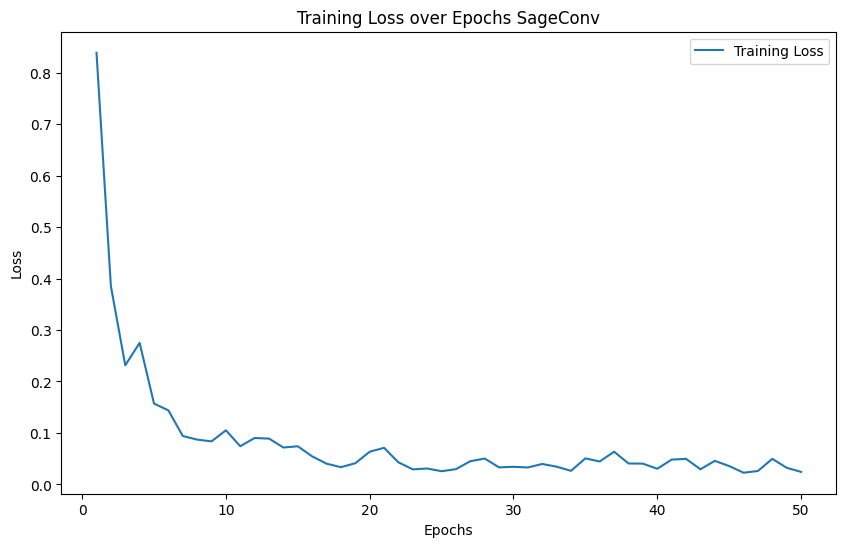

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3316
           1       0.20      0.67      0.31         9

    accuracy                           0.99      3325
   macro avg       0.60      0.83      0.65      3325
weighted avg       1.00      0.99      0.99      3325



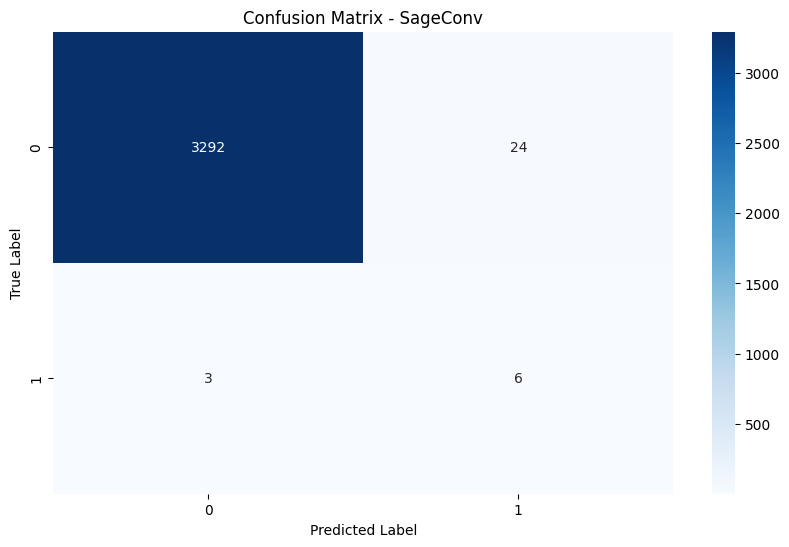

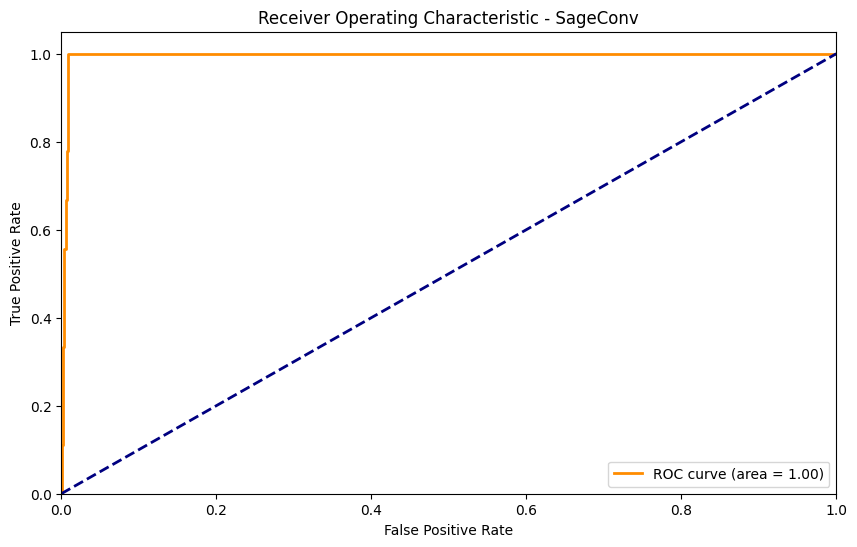

Inside train model with class weights
Epoch 1, Loss: 0.5589955782153361
Epoch 2, Loss: 0.4399211453678815
Epoch 3, Loss: 0.3782017588939356
Epoch 4, Loss: 0.38563185727790644
Epoch 5, Loss: 0.3733858109816261
Epoch 6, Loss: 0.35568172832869965
Epoch 7, Loss: 0.3068487250610538
Epoch 8, Loss: 0.2967565427331821
Epoch 9, Loss: 0.29611550814107707
Epoch 10, Loss: 0.28277256517954497
Epoch 11, Loss: 0.2952919109198062
Epoch 12, Loss: 0.26947504367031483
Epoch 13, Loss: 0.2608518071634614
Epoch 14, Loss: 0.21155607716544814
Epoch 15, Loss: 0.21165486927265706
Epoch 16, Loss: 0.19010063100849156
Epoch 17, Loss: 0.15511753495134736
Epoch 18, Loss: 0.1700429149862865
Epoch 19, Loss: 0.1688051460634755
Epoch 20, Loss: 0.13317422625487266
Epoch 21, Loss: 0.14777375065276158
Epoch 22, Loss: 0.12967853195226306
Epoch 23, Loss: 0.12516260449774563
Epoch 24, Loss: 0.15635056081278573
Epoch 25, Loss: 0.13420078207475497
Epoch 26, Loss: 0.13138752862932565
Epoch 27, Loss: 0.14513023265855104
Epoch 28,

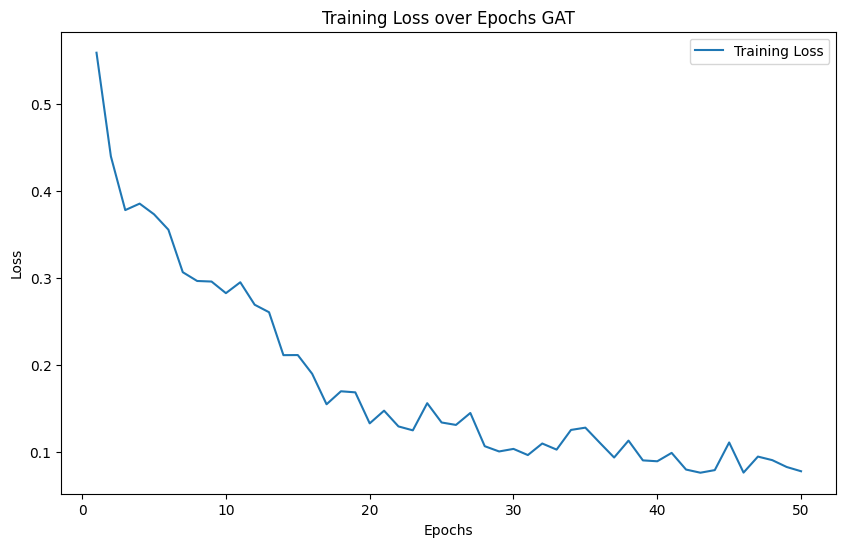

              precision    recall  f1-score   support

           0       1.00      0.97      0.99      3316
           1       0.06      0.56      0.10         9

    accuracy                           0.97      3325
   macro avg       0.53      0.76      0.54      3325
weighted avg       1.00      0.97      0.98      3325



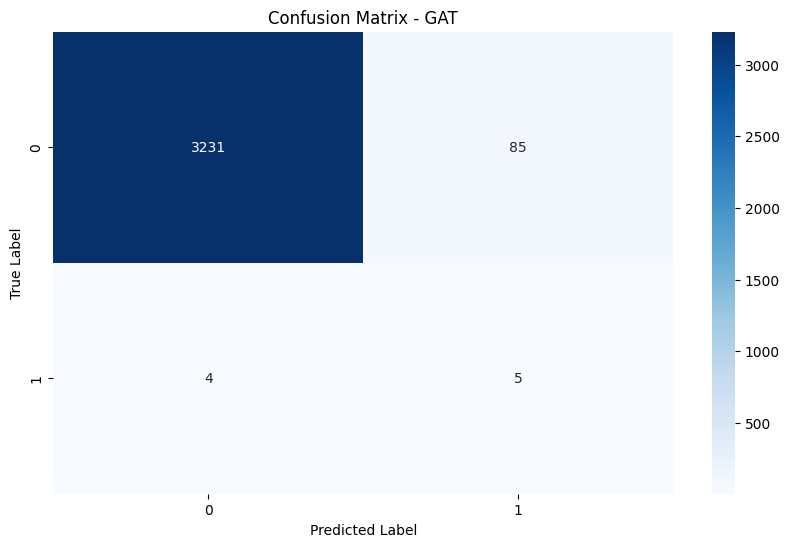

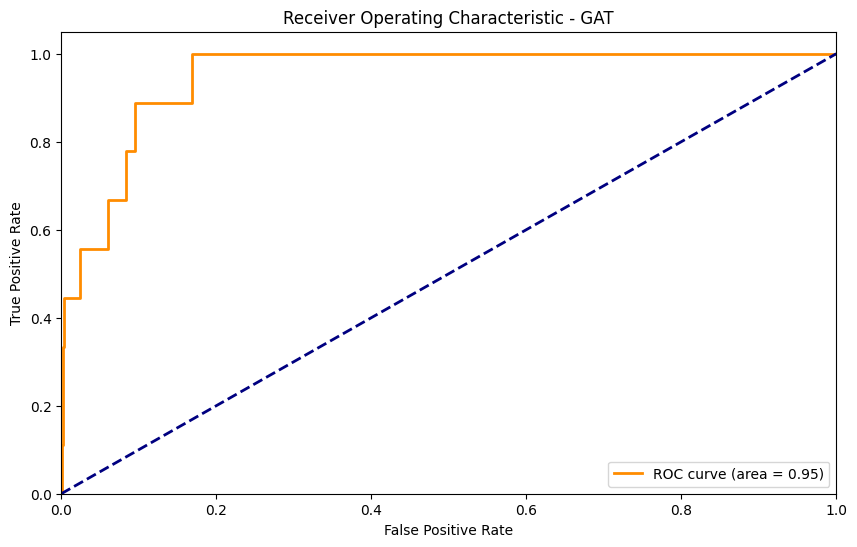

Inside train model with class weights
Epoch 1, Loss: 0.6973538735410725
Epoch 2, Loss: 0.3804587789851686
Epoch 3, Loss: 0.22860766141472952
Epoch 4, Loss: 0.20693805781395538
Epoch 5, Loss: 0.14348256553563735
Epoch 6, Loss: 0.06587591623563481
Epoch 7, Loss: 0.0929823238807528
Epoch 8, Loss: 0.08051432586153565
Epoch 9, Loss: 0.05240066806056901
Epoch 10, Loss: 0.036470199168315565
Epoch 11, Loss: 0.04190148660690402
Epoch 12, Loss: 0.06062196951572095
Epoch 13, Loss: 0.06535553290640288
Epoch 14, Loss: 0.060071960096652416
Epoch 15, Loss: 0.04462033986625181
Epoch 16, Loss: 0.042266873422150915
Epoch 17, Loss: 0.07375562849135706
Epoch 18, Loss: 0.031181173603450272
Epoch 19, Loss: 0.03582614031620324
Epoch 20, Loss: 0.057009311716841614
Epoch 21, Loss: 0.09219976262766463
Epoch 22, Loss: 0.03881488773091089
Epoch 23, Loss: 0.025293200706389896
Epoch 24, Loss: 0.02807147803832777
Epoch 25, Loss: 0.02126106129609347
Epoch 26, Loss: 0.018328072814177216
Epoch 27, Loss: 0.0246649496382

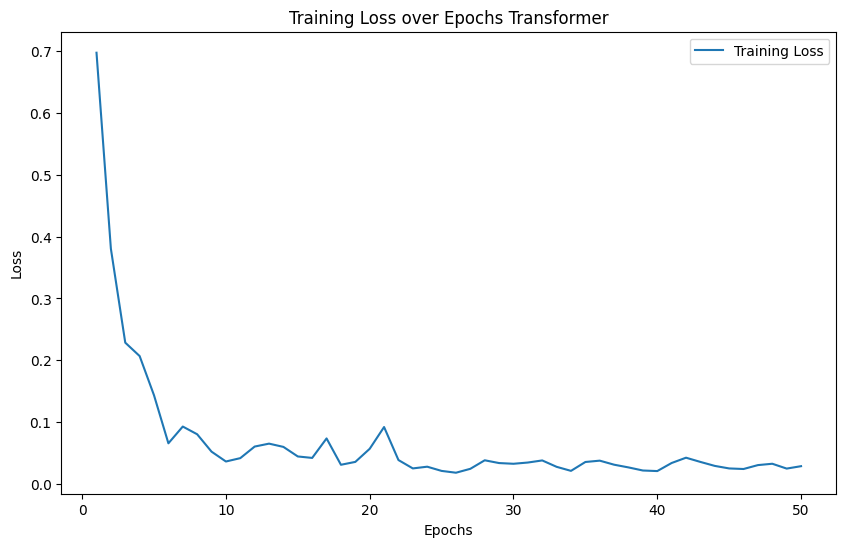

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3316
           1       0.23      0.67      0.34         9

    accuracy                           0.99      3325
   macro avg       0.61      0.83      0.67      3325
weighted avg       1.00      0.99      0.99      3325



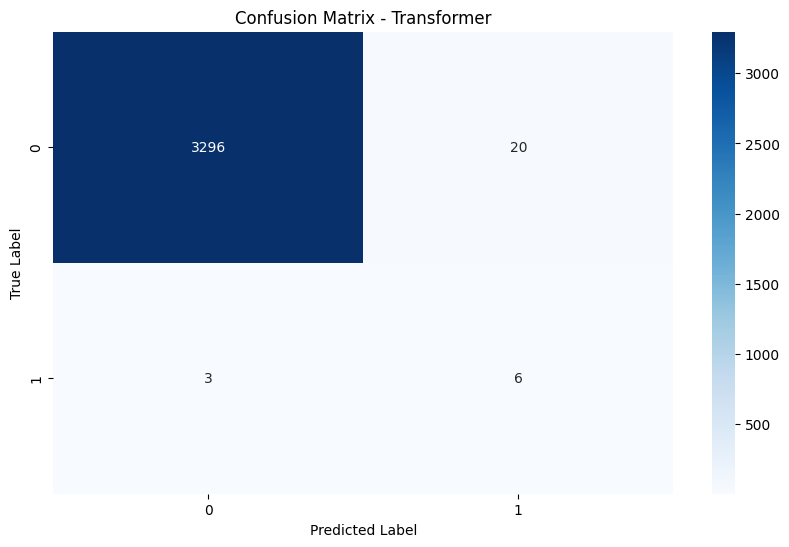

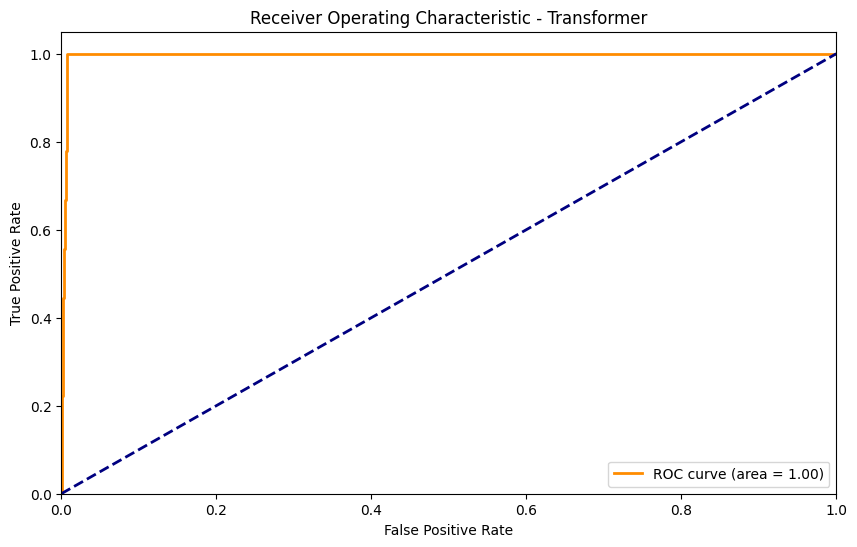

Inside train model with class weights
Epoch 1, Loss: 0.5832238339859507
Epoch 2, Loss: 0.4263460388326127
Epoch 3, Loss: 0.4138337525984515
Epoch 4, Loss: 0.3947983319344728
Epoch 5, Loss: 0.38495518315745436
Epoch 6, Loss: 0.38921308339289995
Epoch 7, Loss: 0.3623454902807008
Epoch 8, Loss: 0.362492143459942
Epoch 9, Loss: 0.34149705343272374
Epoch 10, Loss: 0.31190224753125856
Epoch 11, Loss: 0.33493145684833114
Epoch 12, Loss: 0.32513841136318183
Epoch 13, Loss: 0.31308006989243237
Epoch 14, Loss: 0.28763297362172086
Epoch 15, Loss: 0.2900133568631566
Epoch 16, Loss: 0.31475455621662346
Epoch 17, Loss: 0.2989350944433523
Epoch 18, Loss: 0.2679112061210301
Epoch 19, Loss: 0.27484981067802594
Epoch 20, Loss: 0.2847428870913775
Epoch 21, Loss: 0.2762426817384751
Epoch 22, Loss: 0.3028237696575082
Epoch 23, Loss: 0.2715606106364209
Epoch 24, Loss: 0.2741354639115541
Epoch 25, Loss: 0.2689628852126391
Epoch 26, Loss: 0.2784524624762328
Epoch 27, Loss: 0.27127993090645125
Epoch 28, Loss: 

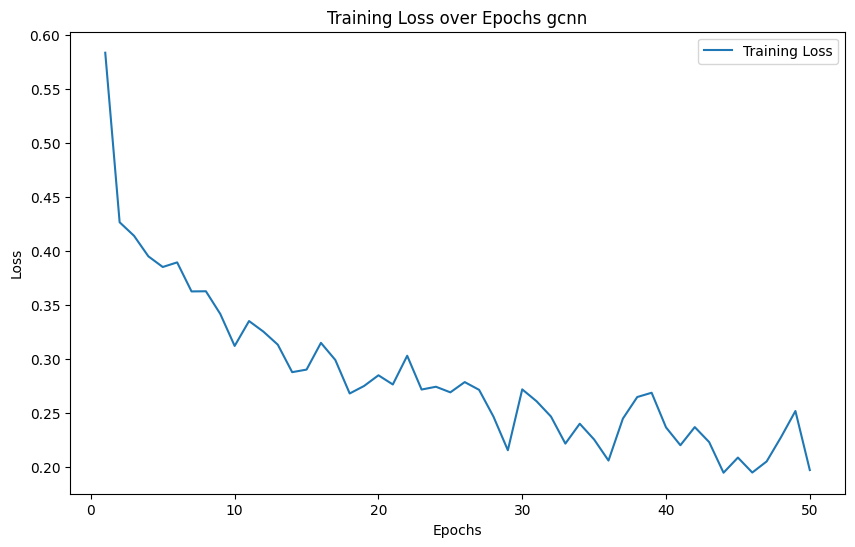

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3316
           1       0.08      0.44      0.14         9

    accuracy                           0.98      3325
   macro avg       0.54      0.72      0.56      3325
weighted avg       1.00      0.98      0.99      3325



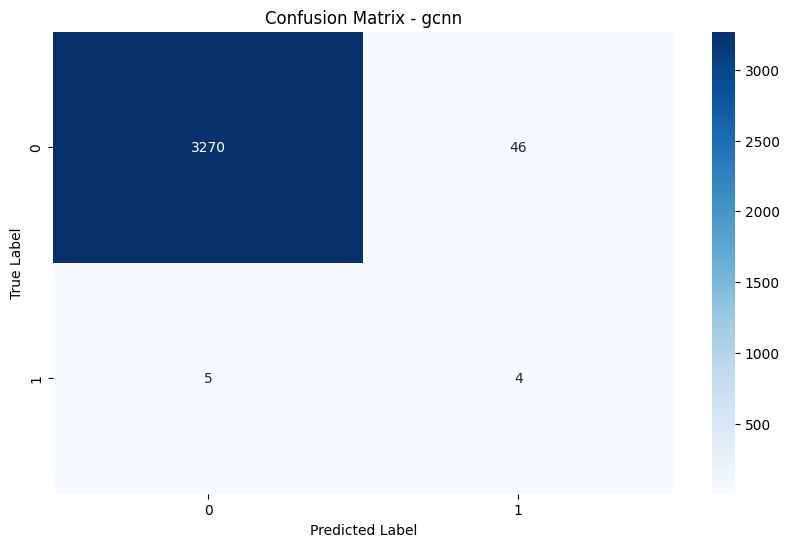

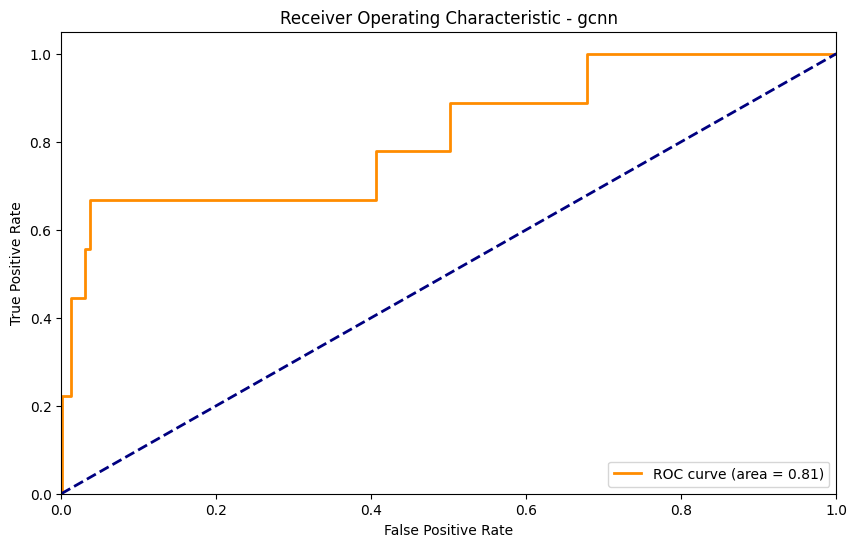

{'type10_label': {'GSageConv': 0.9918796992481203, 'GAT': 0.9732330827067669, 'GTransformer': 0.9930827067669173, 'GCNN': 0.9846616541353383}}
type1_label_


100%|██████████| 2079/2079 [00:31<00:00, 66.86it/s]
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


train_data:1455
test_data:624
Inside train model with class weights
Epoch 1, Loss: 0.5899715965674461
Epoch 2, Loss: 0.28656089471896057
Epoch 3, Loss: 0.13442730643462553
Epoch 4, Loss: 0.09314053202473113
Epoch 5, Loss: 0.04154345196287107
Epoch 6, Loss: 0.04156436531490687
Epoch 7, Loss: 0.10088697151766847
Epoch 8, Loss: 0.09667088239802979
Epoch 9, Loss: 0.017021185330003904
Epoch 10, Loss: 0.008188709681195653
Epoch 11, Loss: 0.028455971430167152
Epoch 12, Loss: 0.05525701918035655
Epoch 13, Loss: 0.04352603845536183
Epoch 14, Loss: 0.002996678017513224
Epoch 15, Loss: 0.03863146609293598
Epoch 16, Loss: 0.009429449279907756
Epoch 17, Loss: 0.14271640746744158
Epoch 18, Loss: 0.032816017517926295
Epoch 19, Loss: 0.018998607852035606
Epoch 20, Loss: 0.05104573598098638
Epoch 21, Loss: 0.027380355744516357
Epoch 22, Loss: 0.012314803952429666
Epoch 23, Loss: 0.01360098085443378
Epoch 24, Loss: 0.00714647436558627
Epoch 25, Loss: 0.0035478515723614532
Epoch 26, Loss: 0.0020193575341

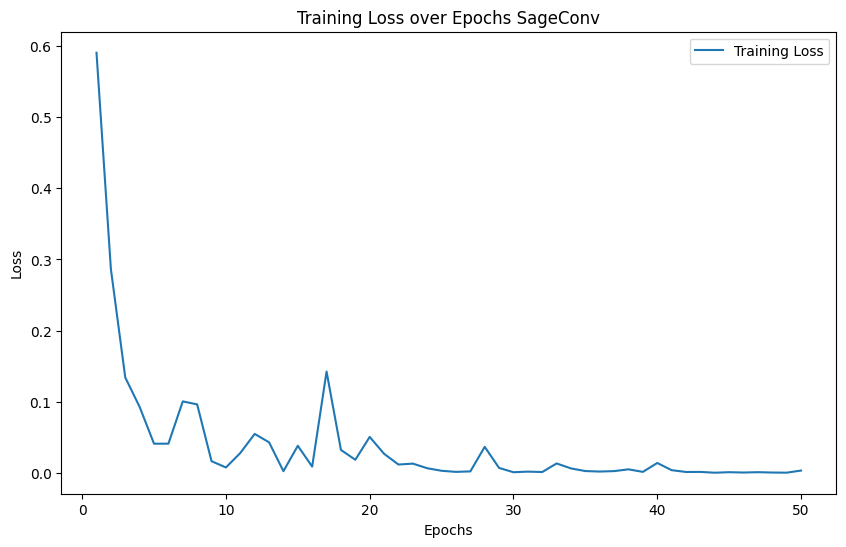

c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-define

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1637
           1       0.00      0.00      0.00         0

    accuracy                           1.00      1637
   macro avg       0.50      0.50      0.50      1637
weighted avg       1.00      1.00      1.00      1637



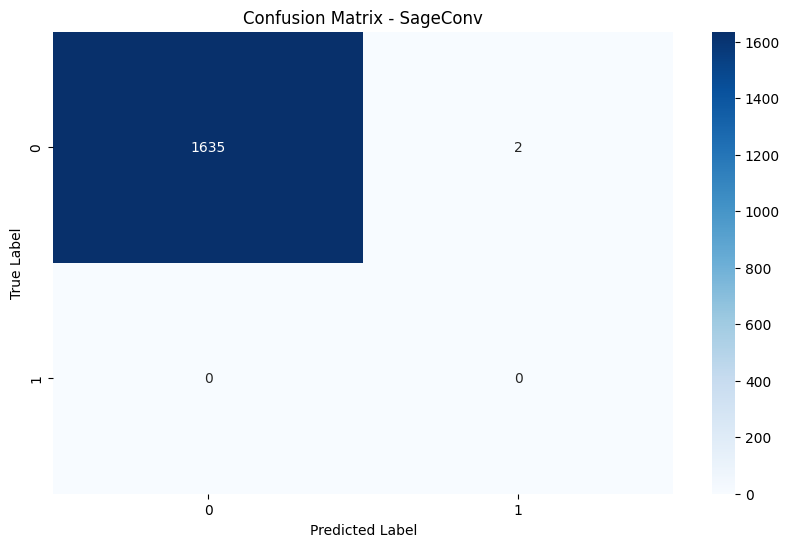

c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


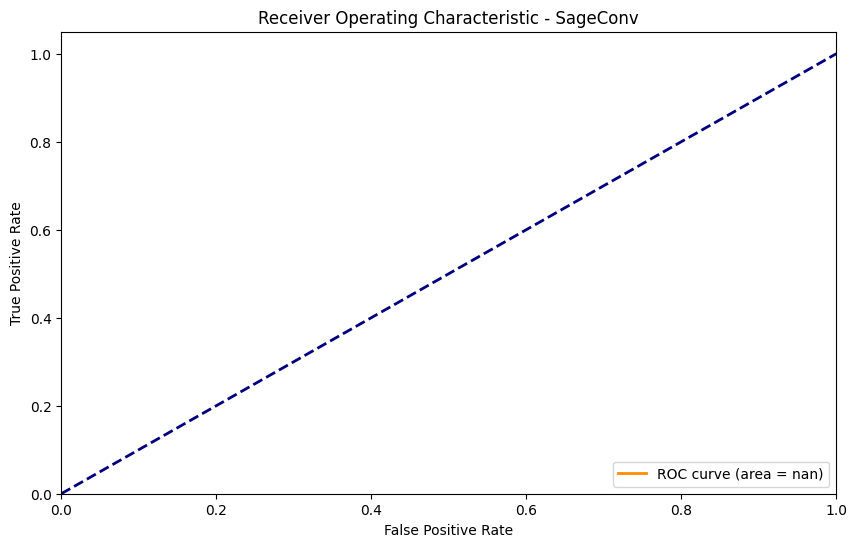

Inside train model with class weights
Epoch 1, Loss: 0.46364262724376243
Epoch 2, Loss: 0.3143210938281339
Epoch 3, Loss: 0.291218733900915
Epoch 4, Loss: 0.27501776454079413
Epoch 5, Loss: 0.25487149156549055
Epoch 6, Loss: 0.254844320067407
Epoch 7, Loss: 0.2693511801569358
Epoch 8, Loss: 0.2400843055675859
Epoch 9, Loss: 0.22750068682691324
Epoch 10, Loss: 0.23898950231302044
Epoch 11, Loss: 0.22296986785595832
Epoch 12, Loss: 0.20273629565844717
Epoch 13, Loss: 0.21645734677820103
Epoch 14, Loss: 0.17438323042638923
Epoch 15, Loss: 0.2063906882768092
Epoch 16, Loss: 0.16420830863163524
Epoch 17, Loss: 0.1802149043701913
Epoch 18, Loss: 0.14080448078153573
Epoch 19, Loss: 0.12034843485478473
Epoch 20, Loss: 0.11216091734114224
Epoch 21, Loss: 0.12273368608894879
Epoch 22, Loss: 0.1304648887143349
Epoch 23, Loss: 0.10210862642397052
Epoch 24, Loss: 0.10857643268030623
Epoch 25, Loss: 0.07987868578335189
Epoch 26, Loss: 0.08605081085419364
Epoch 27, Loss: 0.05894624775923465
Epoch 28,

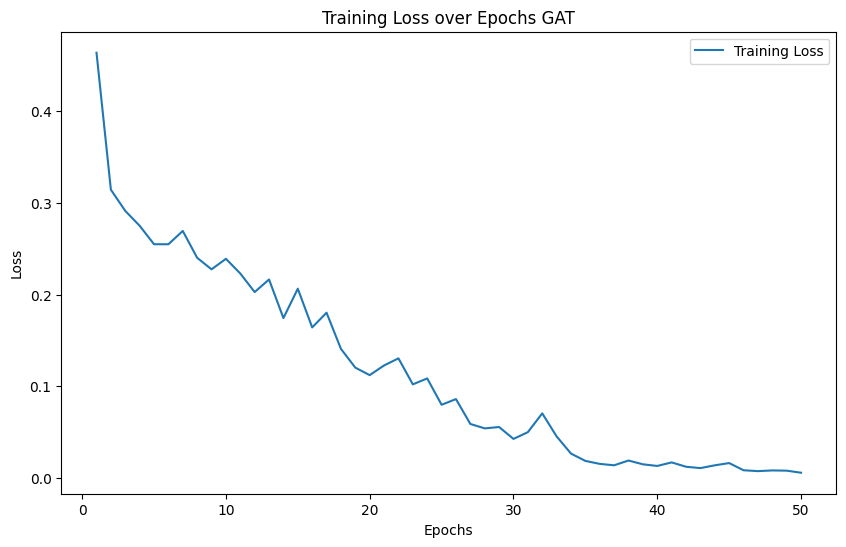

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1637
           1       0.00      0.00      0.00         0

    accuracy                           1.00      1637
   macro avg       0.50      0.50      0.50      1637
weighted avg       1.00      1.00      1.00      1637



c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-define

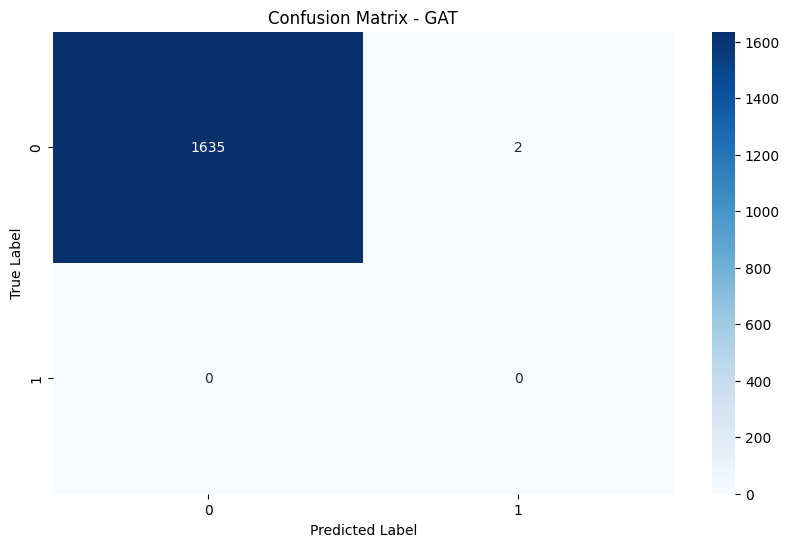

c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


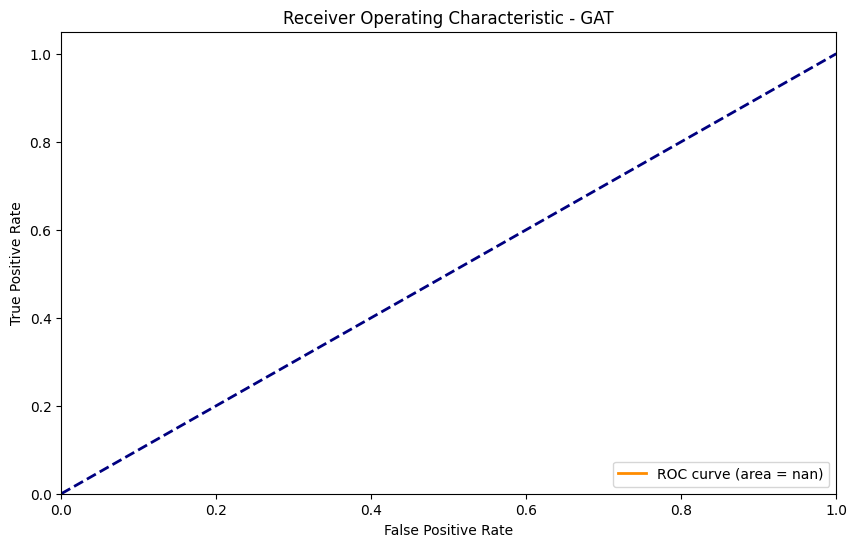

Inside train model with class weights
Epoch 1, Loss: 0.4945652832418842
Epoch 2, Loss: 0.23074437845903245
Epoch 3, Loss: 0.10277731407879163
Epoch 4, Loss: 0.10083221636064675
Epoch 5, Loss: 0.09850027457729954
Epoch 6, Loss: 0.028535251184265413
Epoch 7, Loss: 0.012866637441734581
Epoch 8, Loss: 0.06403340259187287
Epoch 9, Loss: 0.01853026624303311
Epoch 10, Loss: 0.052764569495870405
Epoch 11, Loss: 0.10431792069373289
Epoch 12, Loss: 0.11075509668317744
Epoch 13, Loss: 0.09160869658681685
Epoch 14, Loss: 0.01594080459124044
Epoch 15, Loss: 0.010337237831782144
Epoch 16, Loss: 0.009751574768059705
Epoch 17, Loss: 0.07092691489521277
Epoch 18, Loss: 0.02114824752377741
Epoch 19, Loss: 0.0147966532509283
Epoch 20, Loss: 0.03502428119574451
Epoch 21, Loss: 0.011405280412280104
Epoch 22, Loss: 0.017616452767588667
Epoch 23, Loss: 0.0128403364719618
Epoch 24, Loss: 0.016761571127379127
Epoch 25, Loss: 0.00722529244929952
Epoch 26, Loss: 0.004901683494608733
Epoch 27, Loss: 0.00643130314

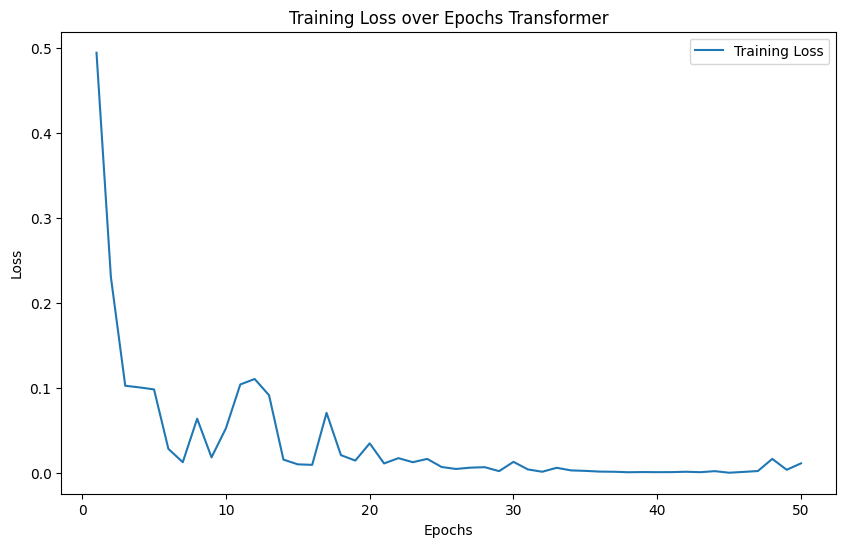

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1637
           1       0.00      0.00      0.00         0

    accuracy                           1.00      1637
   macro avg       0.50      0.50      0.50      1637
weighted avg       1.00      1.00      1.00      1637



c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-define

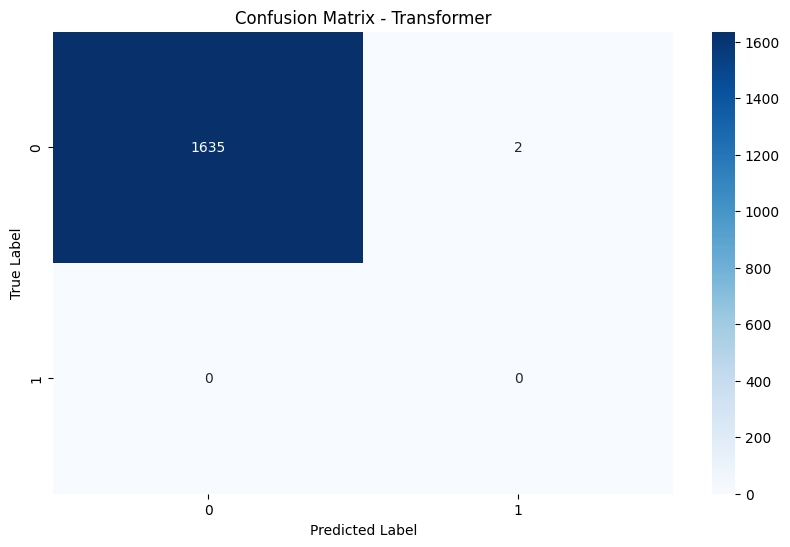

c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


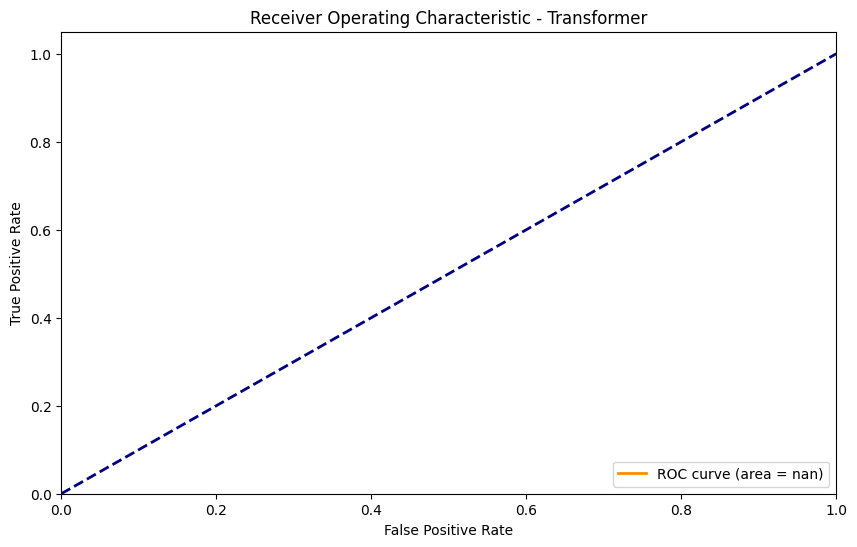

Inside train model with class weights
Epoch 1, Loss: 0.5036039008232562
Epoch 2, Loss: 0.3549273456244365
Epoch 3, Loss: 0.3561921229019113
Epoch 4, Loss: 0.26259267143905163
Epoch 5, Loss: 0.24019906009830858
Epoch 6, Loss: 0.2537008251427956
Epoch 7, Loss: 0.2375844370816713
Epoch 8, Loss: 0.21247537782334763
Epoch 9, Loss: 0.19070258364081383
Epoch 10, Loss: 0.16171995159643499
Epoch 11, Loss: 0.1717620209345351
Epoch 12, Loss: 0.17624615151030215
Epoch 13, Loss: 0.14028476672651974
Epoch 14, Loss: 0.13888669139503138
Epoch 15, Loss: 0.15432624518871307
Epoch 16, Loss: 0.12569368088051028
Epoch 17, Loss: 0.14100418332964182
Epoch 18, Loss: 0.13443933170207817
Epoch 19, Loss: 0.11326191742378085
Epoch 20, Loss: 0.0777655762174855
Epoch 21, Loss: 0.14984399031685747
Epoch 22, Loss: 0.09750769354160065
Epoch 23, Loss: 0.12028788365221219
Epoch 24, Loss: 0.06050985524147425
Epoch 25, Loss: 0.13810934049441762
Epoch 26, Loss: 0.11956082583081139
Epoch 27, Loss: 0.12767916225382817
Epoch 

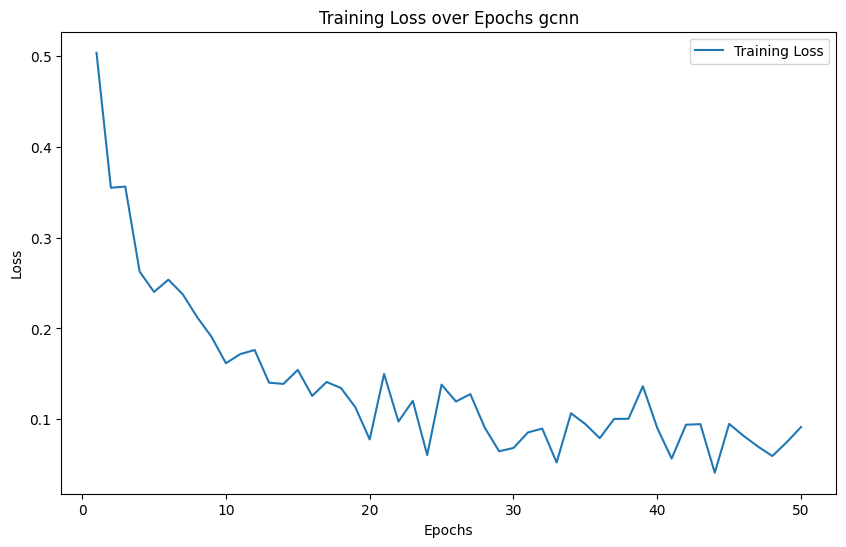

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1637
           1       0.00      0.00      0.00         0

    accuracy                           1.00      1637
   macro avg       0.50      0.50      0.50      1637
weighted avg       1.00      1.00      1.00      1637



c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-define

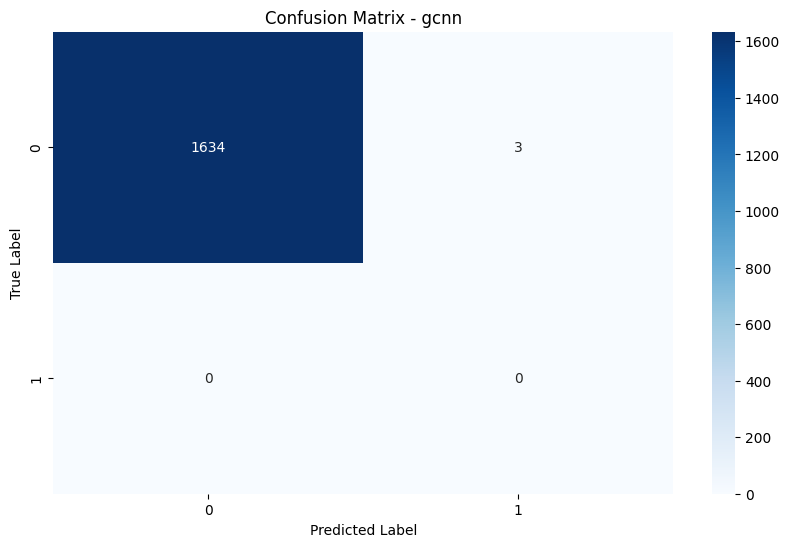

c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


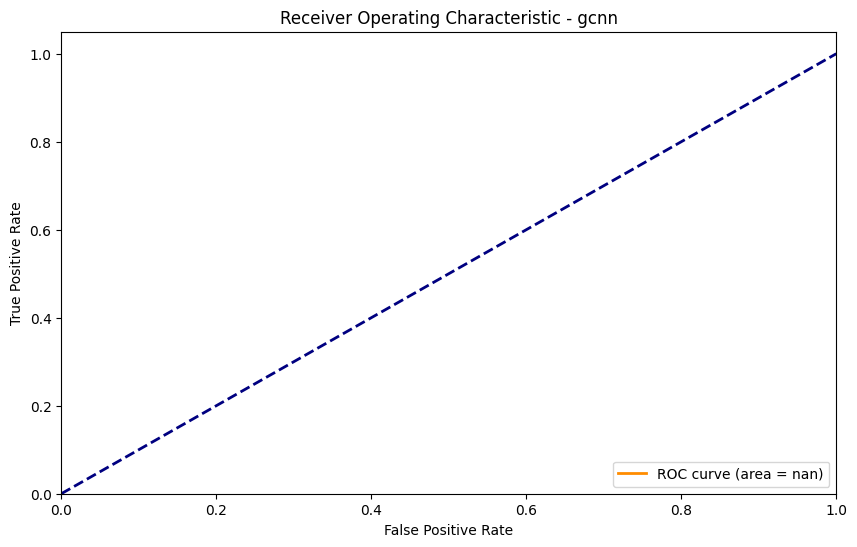

{'type10_label': {'GSageConv': 0.9918796992481203, 'GAT': 0.9732330827067669, 'GTransformer': 0.9930827067669173, 'GCNN': 0.9846616541353383}, 'type1_label_': {'GSageConv': 0.9987782529016493, 'GAT': 0.9987782529016493, 'GTransformer': 0.9987782529016493, 'GCNN': 0.998167379352474}}
type2_label_


100%|██████████| 1342/1342 [00:21<00:00, 61.81it/s]
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


train_data:939
test_data:403
Inside train model with class weights
Epoch 1, Loss: 0.6941238686228947
Epoch 2, Loss: 0.3152535243115077
Epoch 3, Loss: 0.20244085478285948
Epoch 4, Loss: 0.25329115831603605
Epoch 5, Loss: 0.28661808629209795
Epoch 6, Loss: 0.24736204144234458
Epoch 7, Loss: 0.2881507957354188
Epoch 8, Loss: 0.1858640388896068
Epoch 9, Loss: 0.09412810982515414
Epoch 10, Loss: 0.16669528180112442
Epoch 11, Loss: 0.14766502187897762
Epoch 12, Loss: 0.07985874299580852
Epoch 13, Loss: 0.08417198166716844
Epoch 14, Loss: 0.037385629082564265
Epoch 15, Loss: 0.16861079161559853
Epoch 16, Loss: 0.08009104216471315
Epoch 17, Loss: 0.06180270668119192
Epoch 18, Loss: 0.20810725912451744
Epoch 19, Loss: 0.06706530004739761
Epoch 20, Loss: 0.040019006619695575
Epoch 21, Loss: 0.060990624913635355
Epoch 22, Loss: 0.03287800253601745
Epoch 23, Loss: 0.05233257760604223
Epoch 24, Loss: 0.050286681624129415
Epoch 25, Loss: 0.060738943843171
Epoch 26, Loss: 0.05629994747384141
Epoch 27

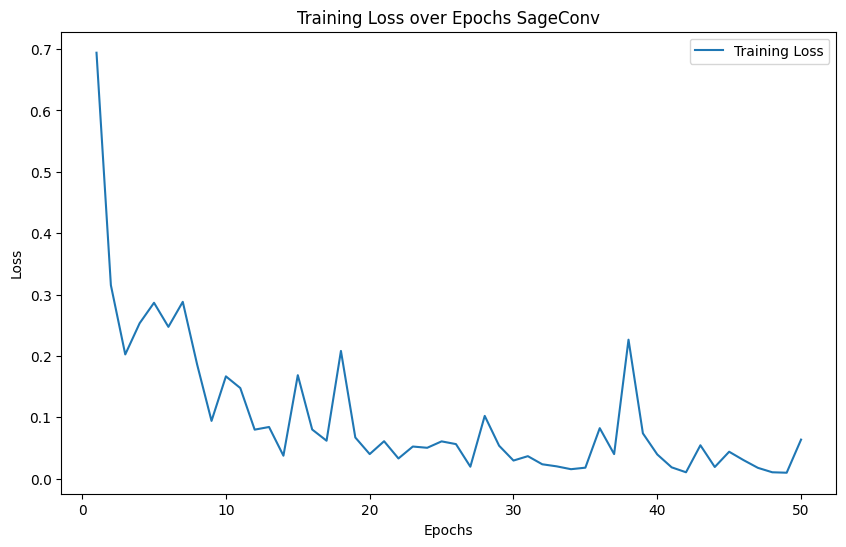

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1982
           1       0.33      1.00      0.50         4

    accuracy                           1.00      1986
   macro avg       0.67      1.00      0.75      1986
weighted avg       1.00      1.00      1.00      1986



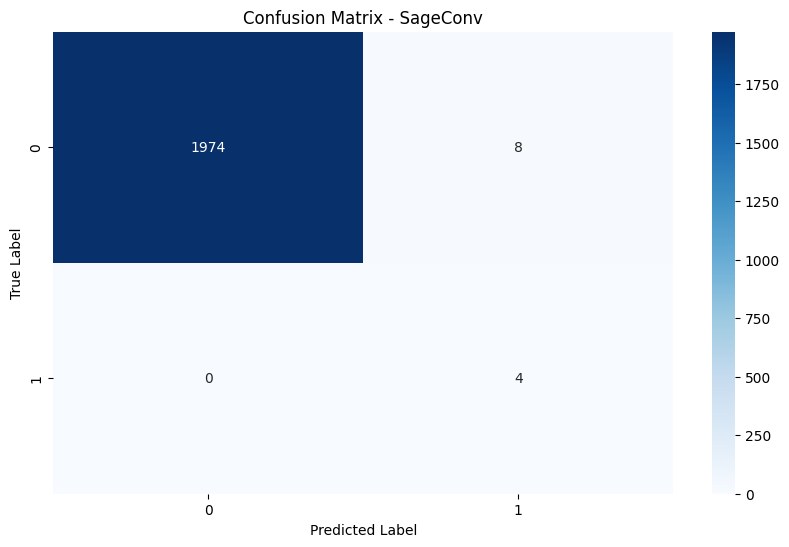

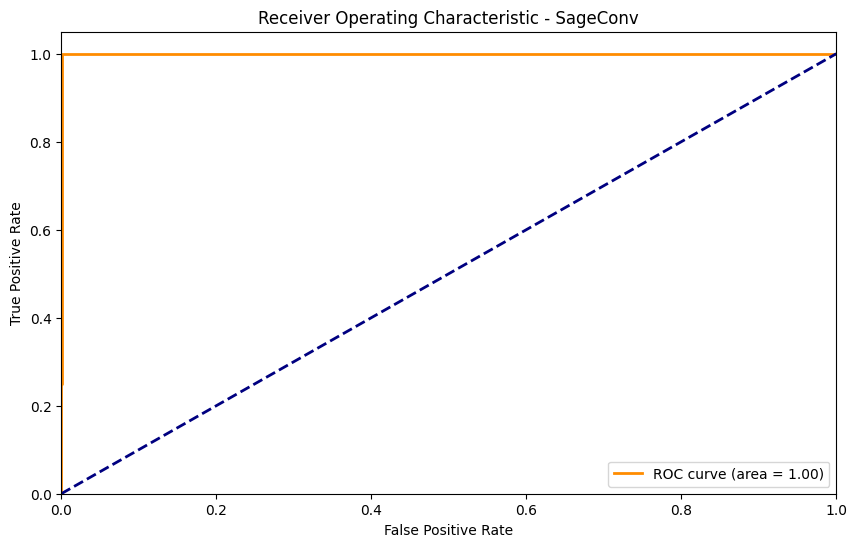

Inside train model with class weights
Epoch 1, Loss: 0.5017123181993762
Epoch 2, Loss: 0.26116805896162987
Epoch 3, Loss: 0.28512456454336643
Epoch 4, Loss: 0.24184587535758814
Epoch 5, Loss: 0.1929057597493132
Epoch 6, Loss: 0.2033703594158093
Epoch 7, Loss: 0.2395691119755308
Epoch 8, Loss: 0.25336839569111663
Epoch 9, Loss: 0.21996979812781017
Epoch 10, Loss: 0.21762129378815492
Epoch 11, Loss: 0.16968485719213883
Epoch 12, Loss: 0.18006381603578728
Epoch 13, Loss: 0.18723894283175468
Epoch 14, Loss: 0.2501969172308842
Epoch 15, Loss: 0.18591641392558814
Epoch 16, Loss: 0.20907330897947152
Epoch 17, Loss: 0.17832418512552978
Epoch 18, Loss: 0.21924846849093835
Epoch 19, Loss: 0.17409039847552776
Epoch 20, Loss: 0.21030854588995376
Epoch 21, Loss: 0.17536034155637026
Epoch 22, Loss: 0.1494098591307799
Epoch 23, Loss: 0.23065378945320844
Epoch 24, Loss: 0.1508676699673136
Epoch 25, Loss: 0.1729349392776688
Epoch 26, Loss: 0.15918824194620054
Epoch 27, Loss: 0.2095170237434407
Epoch 28

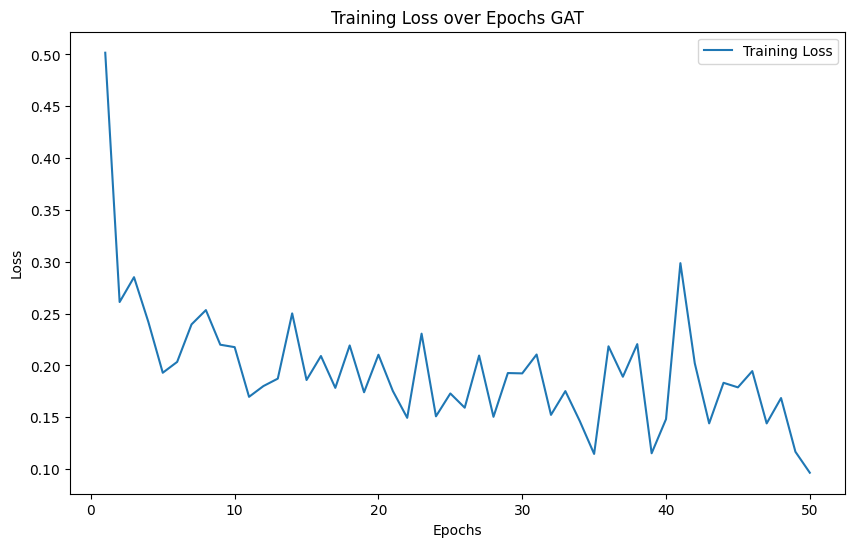

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1982
           1       0.00      0.00      0.00         4

    accuracy                           1.00      1986
   macro avg       0.50      0.50      0.50      1986
weighted avg       1.00      1.00      1.00      1986



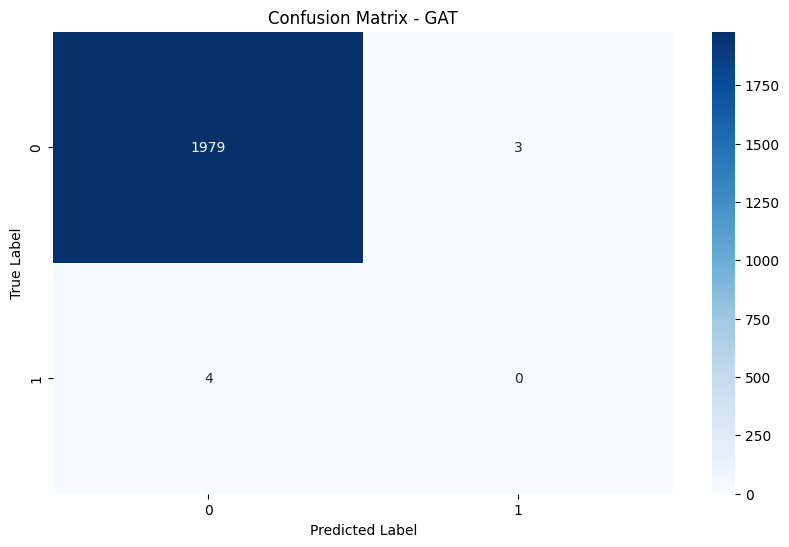

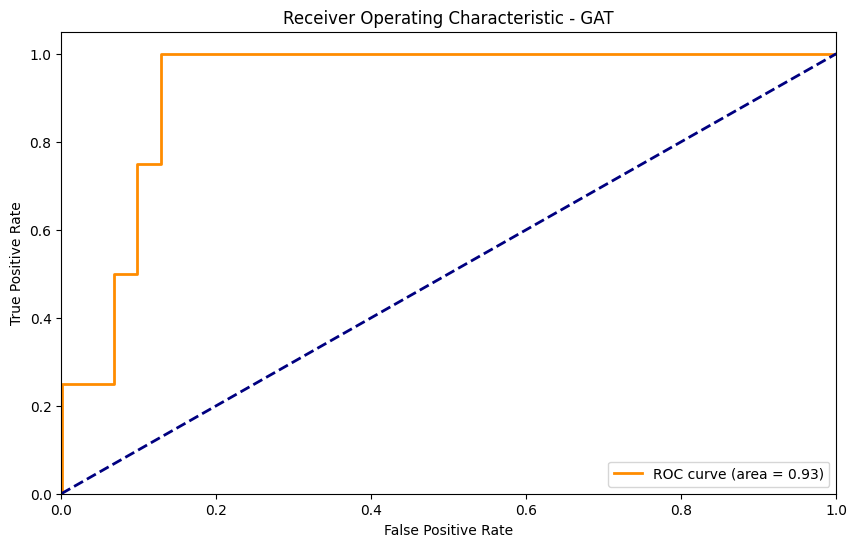

Inside train model with class weights
Epoch 1, Loss: 0.7250996656987506
Epoch 2, Loss: 0.30950014957537253
Epoch 3, Loss: 0.3701186692963044
Epoch 4, Loss: 0.2690845226868987
Epoch 5, Loss: 0.33325705357516805
Epoch 6, Loss: 0.31908745421096685
Epoch 7, Loss: 0.27749912391106285
Epoch 8, Loss: 0.16945553856591383
Epoch 9, Loss: 0.097001593777289
Epoch 10, Loss: 0.12538517356539766
Epoch 11, Loss: 0.0807158234063536
Epoch 12, Loss: 0.13380337888374924
Epoch 13, Loss: 0.16705209552310407
Epoch 14, Loss: 0.20922565017826855
Epoch 15, Loss: 0.06119329364349445
Epoch 16, Loss: 0.07947346745058895
Epoch 17, Loss: 0.08134947580595811
Epoch 18, Loss: 0.1085918696752439
Epoch 19, Loss: 0.15275529740999141
Epoch 20, Loss: 0.09544621830185254
Epoch 21, Loss: 0.03767139185220003
Epoch 22, Loss: 0.05007376212161034
Epoch 23, Loss: 0.03266032012179494
Epoch 24, Loss: 0.1496158924419433
Epoch 25, Loss: 0.07363064740784467
Epoch 26, Loss: 0.03886238816194236
Epoch 27, Loss: 0.029341485118493438
Epoch 

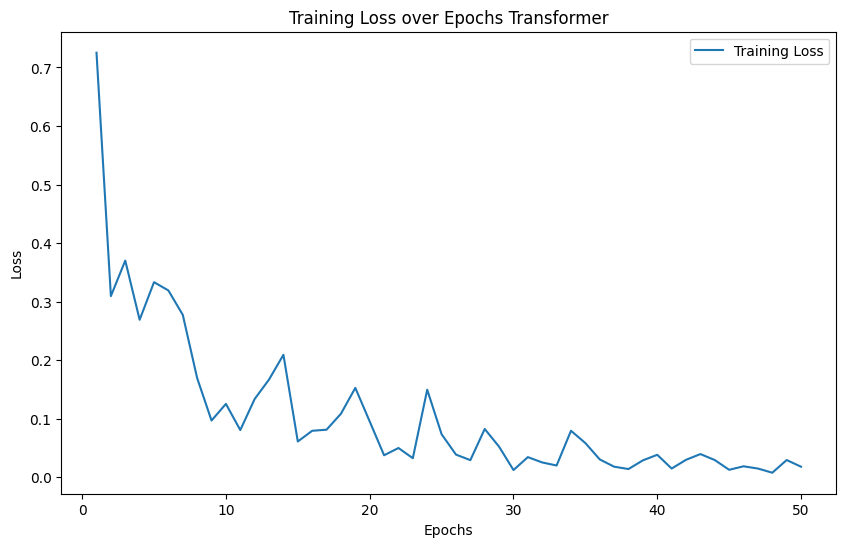

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1982
           1       0.50      1.00      0.67         4

    accuracy                           1.00      1986
   macro avg       0.75      1.00      0.83      1986
weighted avg       1.00      1.00      1.00      1986



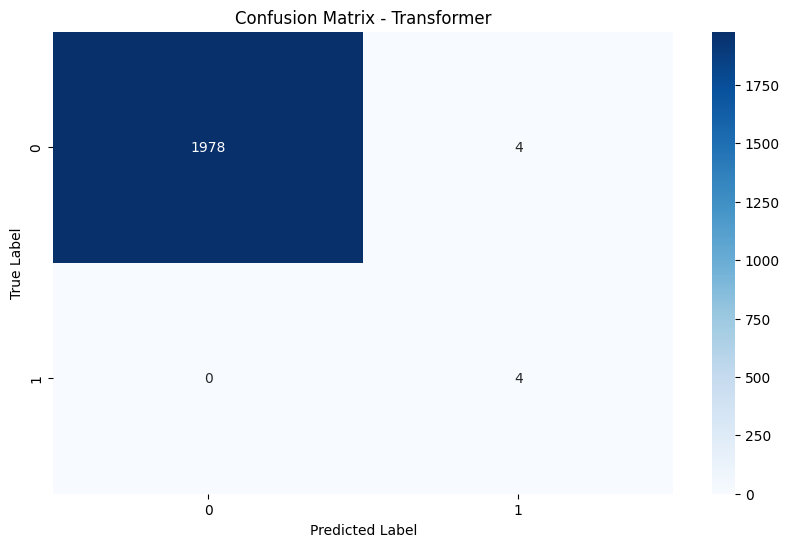

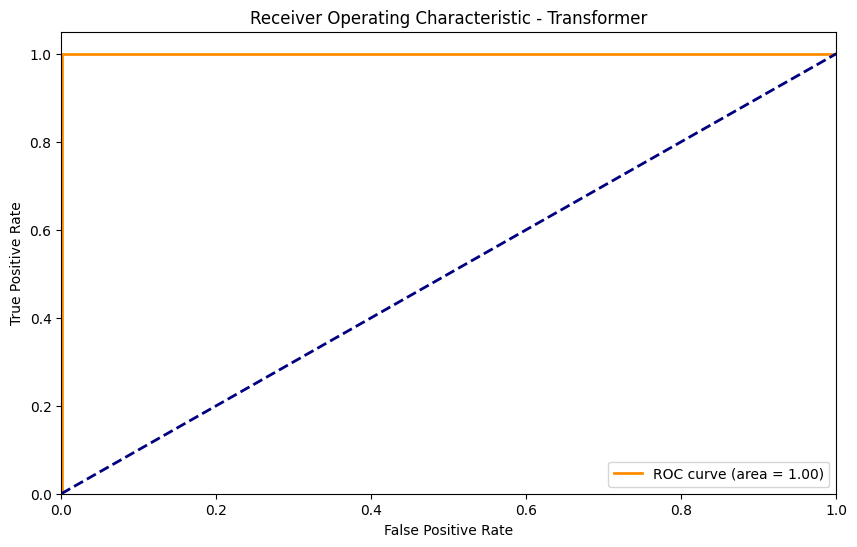

Inside train model with class weights
Epoch 1, Loss: 0.371061353944242
Epoch 2, Loss: 0.26235358013461035
Epoch 3, Loss: 0.24473261597255866
Epoch 4, Loss: 0.2387718600531419
Epoch 5, Loss: 0.21973885310192903
Epoch 6, Loss: 0.21201206985861062
Epoch 7, Loss: 0.21866031816850107
Epoch 8, Loss: 0.17371287861218054
Epoch 9, Loss: 0.210756318581601
Epoch 10, Loss: 0.23103928323835135
Epoch 11, Loss: 0.2090463751927018
Epoch 12, Loss: 0.19157749203344185
Epoch 13, Loss: 0.2199016995728016
Epoch 14, Loss: 0.20261924179891747
Epoch 15, Loss: 0.22720251592497032
Epoch 16, Loss: 0.22057352761427562
Epoch 17, Loss: 0.16284537731359403
Epoch 18, Loss: 0.19293628626813492
Epoch 19, Loss: 0.1822565640633305
Epoch 20, Loss: 0.21896039508283138
Epoch 21, Loss: 0.2082784449060758
Epoch 22, Loss: 0.1767704512303074
Epoch 23, Loss: 0.15645296381165583
Epoch 24, Loss: 0.1623676582550009
Epoch 25, Loss: 0.1923918709779779
Epoch 26, Loss: 0.19938946614662806
Epoch 27, Loss: 0.1723522146542867
Epoch 28, Lo

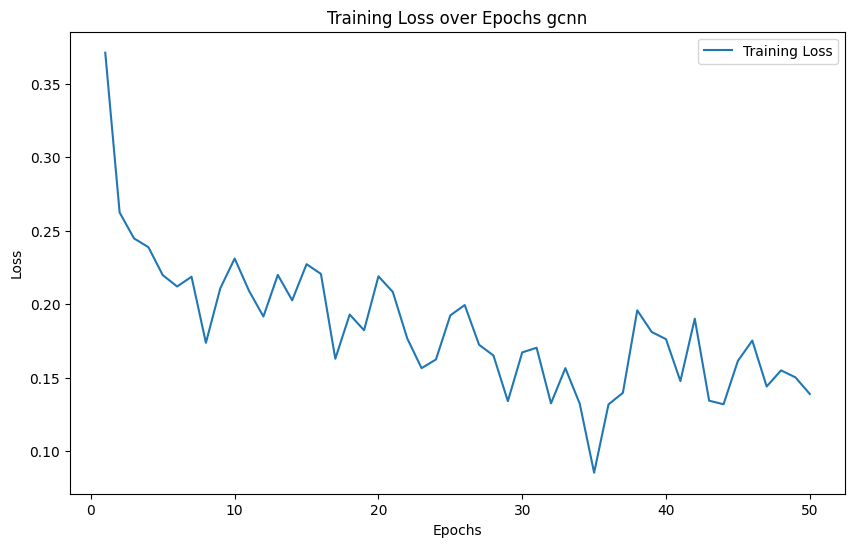

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1982
           1       0.00      0.00      0.00         4

    accuracy                           0.98      1986
   macro avg       0.50      0.49      0.50      1986
weighted avg       1.00      0.98      0.99      1986



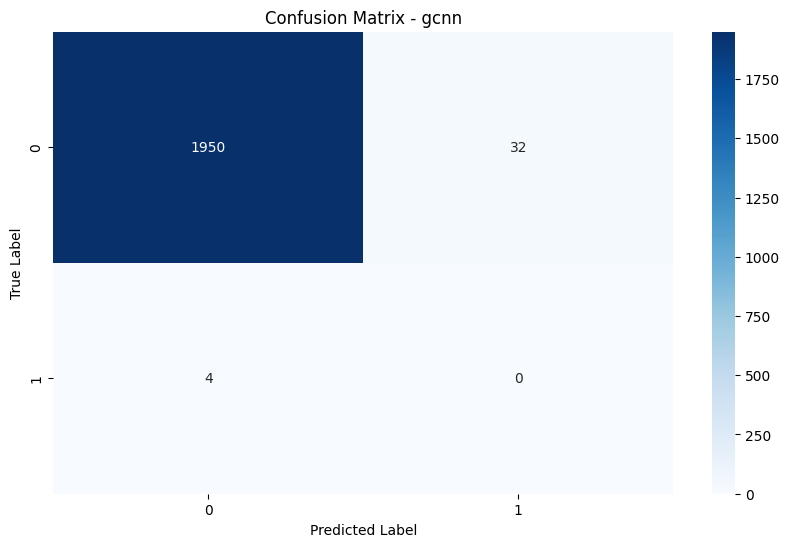

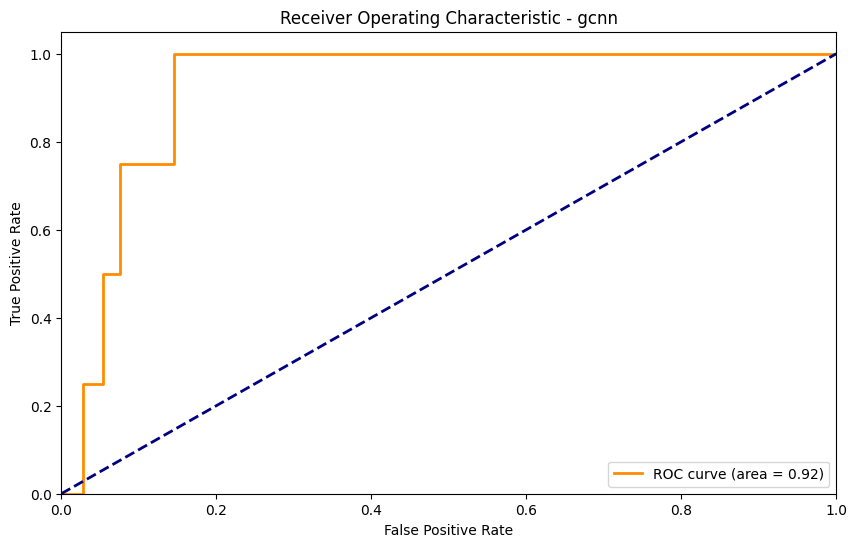

{'type10_label': {'GSageConv': 0.9918796992481203, 'GAT': 0.9732330827067669, 'GTransformer': 0.9930827067669173, 'GCNN': 0.9846616541353383}, 'type1_label_': {'GSageConv': 0.9987782529016493, 'GAT': 0.9987782529016493, 'GTransformer': 0.9987782529016493, 'GCNN': 0.998167379352474}, 'type2_label_': {'GSageConv': 0.9959718026183283, 'GAT': 0.9964753272910373, 'GTransformer': 0.9979859013091642, 'GCNN': 0.9818731117824774}}
type3_label_


100%|██████████| 1975/1975 [00:30<00:00, 63.79it/s]
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


train_data:1382
test_data:593
Inside train model with class weights
Epoch 1, Loss: 0.947146858104547
Epoch 2, Loss: 0.3441422171044079
Epoch 3, Loss: 0.20413861368698152
Epoch 4, Loss: 0.18733043318868361
Epoch 5, Loss: 0.17579012738794766
Epoch 6, Loss: 0.11292842001950537
Epoch 7, Loss: 0.06875859620049596
Epoch 8, Loss: 0.05292165650859137
Epoch 9, Loss: 0.061682065795387396
Epoch 10, Loss: 0.07598549776064994
Epoch 11, Loss: 0.034437112330289725
Epoch 12, Loss: 0.025251717018281026
Epoch 13, Loss: 0.04483156698882918
Epoch 14, Loss: 0.07065941918038086
Epoch 15, Loss: 0.04195476171430941
Epoch 16, Loss: 0.03017857789580541
Epoch 17, Loss: 0.037199650176758456
Epoch 18, Loss: 0.028033539665391963
Epoch 19, Loss: 0.017174267580809432
Epoch 20, Loss: 0.035391174838878214
Epoch 21, Loss: 0.029001494499838867
Epoch 22, Loss: 0.01887450159384488
Epoch 23, Loss: 0.016925542897793508
Epoch 24, Loss: 0.024441718006383697
Epoch 25, Loss: 0.02259898408705009
Epoch 26, Loss: 0.0193499539709591

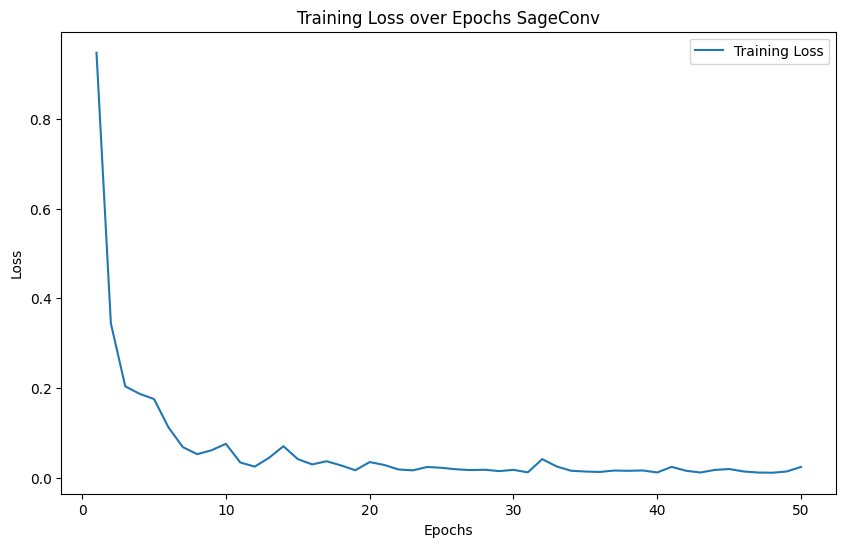

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2136
           1       0.64      1.00      0.78         9

    accuracy                           1.00      2145
   macro avg       0.82      1.00      0.89      2145
weighted avg       1.00      1.00      1.00      2145



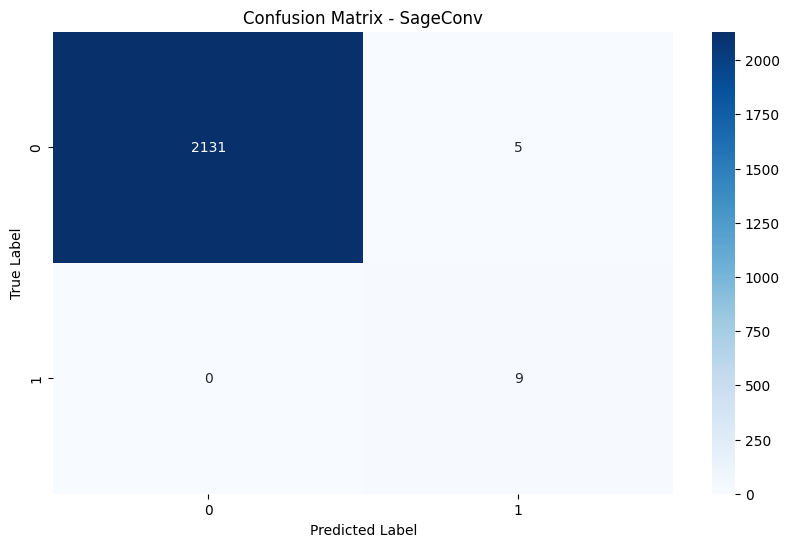

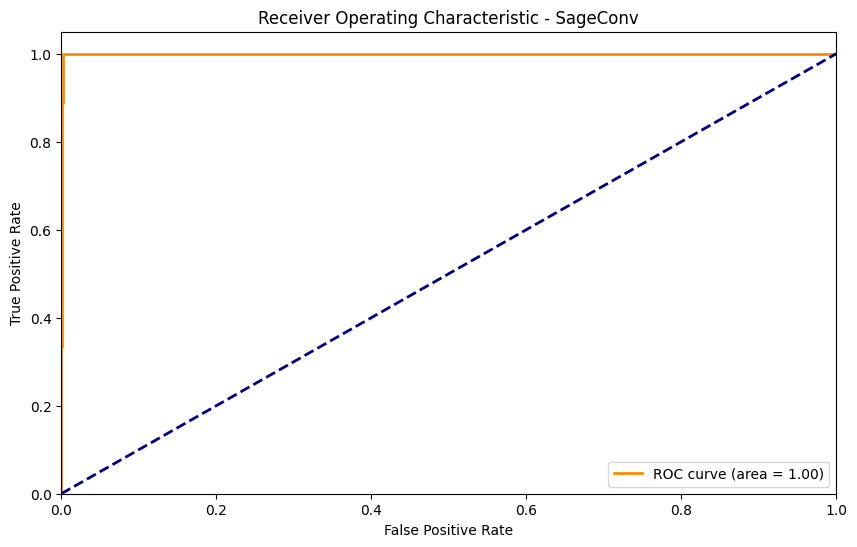

Inside train model with class weights
Epoch 1, Loss: 0.6263006432828578
Epoch 2, Loss: 0.512469008564949
Epoch 3, Loss: 0.47787668217312207
Epoch 4, Loss: 0.43911503069102764
Epoch 5, Loss: 0.4105721131305803
Epoch 6, Loss: 0.3521321107718078
Epoch 7, Loss: 0.24807377692989327
Epoch 8, Loss: 0.1212712326510386
Epoch 9, Loss: 0.05166898382065648
Epoch 10, Loss: 0.027034277588510038
Epoch 11, Loss: 0.030204098592300645
Epoch 12, Loss: 0.030338606511412018
Epoch 13, Loss: 0.02626321776452559
Epoch 14, Loss: 0.03533824113798222
Epoch 15, Loss: 0.023655546560555442
Epoch 16, Loss: 0.023686565303002928
Epoch 17, Loss: 0.020725710675337308
Epoch 18, Loss: 0.016581508887942287
Epoch 19, Loss: 0.03031235870466017
Epoch 20, Loss: 0.0206176935369678
Epoch 21, Loss: 0.01771497300052777
Epoch 22, Loss: 0.02132060867089339
Epoch 23, Loss: 0.019512251008398544
Epoch 24, Loss: 0.013817757105161118
Epoch 25, Loss: 0.015980648892764293
Epoch 26, Loss: 0.015495110269925632
Epoch 27, Loss: 0.0163405865732

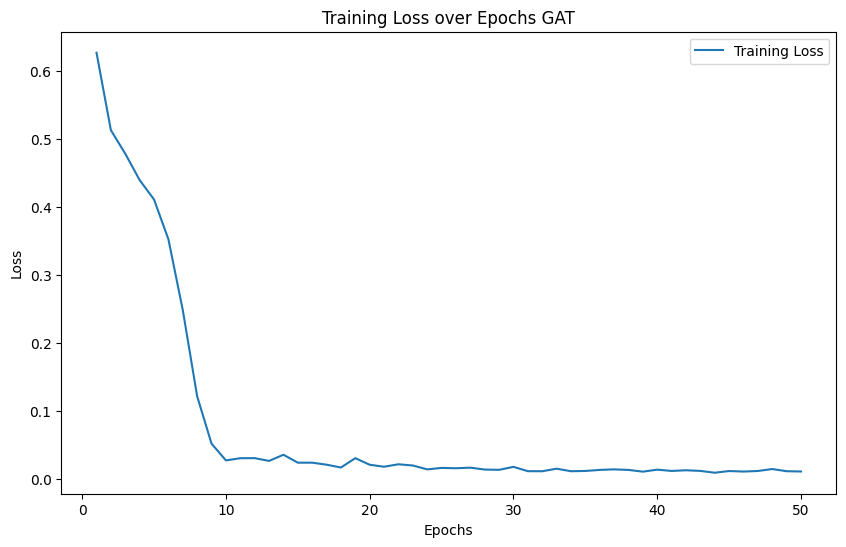

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2136
           1       0.64      1.00      0.78         9

    accuracy                           1.00      2145
   macro avg       0.82      1.00      0.89      2145
weighted avg       1.00      1.00      1.00      2145



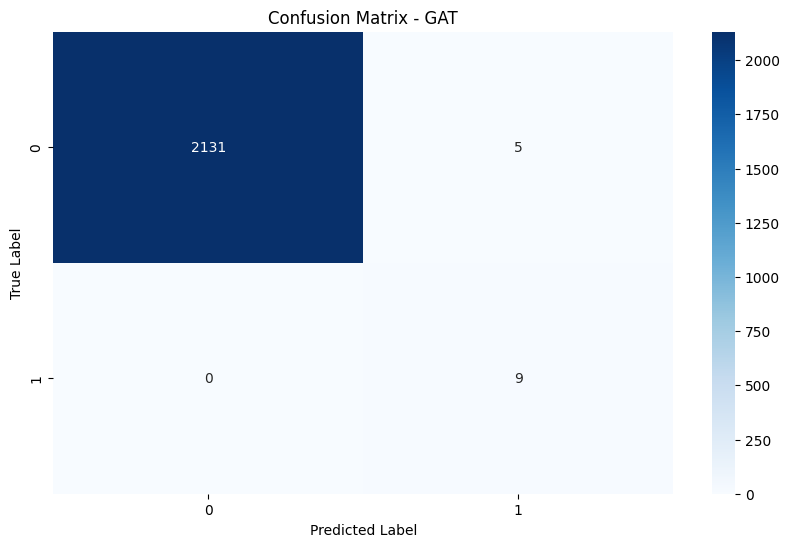

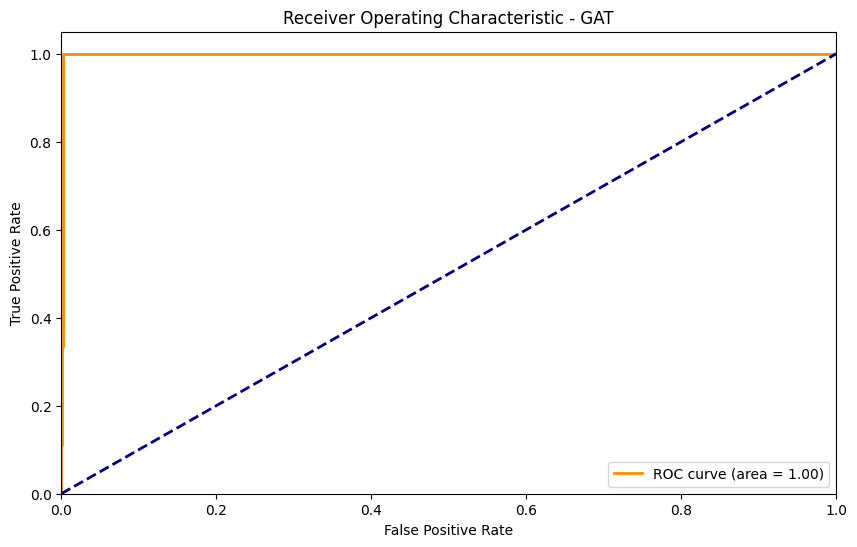

Inside train model with class weights
Epoch 1, Loss: 0.9986731409920718
Epoch 2, Loss: 0.3214819679375399
Epoch 3, Loss: 0.1560957720503211
Epoch 4, Loss: 0.1351600993974981
Epoch 5, Loss: 0.09207789500413294
Epoch 6, Loss: 0.08716301232396456
Epoch 7, Loss: 0.09755222485612401
Epoch 8, Loss: 0.05867486519061706
Epoch 9, Loss: 0.06524889678588476
Epoch 10, Loss: 0.05411183058723426
Epoch 11, Loss: 0.08633106236547147
Epoch 12, Loss: 0.06777018211273984
Epoch 13, Loss: 0.04345188581977378
Epoch 14, Loss: 0.03324085382204926
Epoch 15, Loss: 0.018145916306821164
Epoch 16, Loss: 0.031730973821884785
Epoch 17, Loss: 0.01954587300960239
Epoch 18, Loss: 0.03471447283730165
Epoch 19, Loss: 0.02953206340250538
Epoch 20, Loss: 0.024303475528788775
Epoch 21, Loss: 0.025061005818067562
Epoch 22, Loss: 0.02878658936292182
Epoch 23, Loss: 0.01654802843586367
Epoch 24, Loss: 0.016145762158161728
Epoch 25, Loss: 0.016495398259311598
Epoch 26, Loss: 0.01572088271177563
Epoch 27, Loss: 0.019140337163414

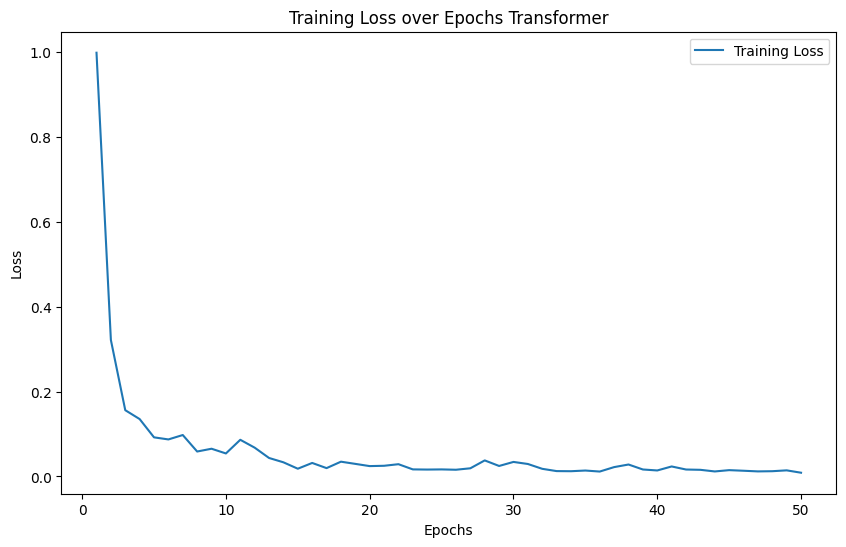

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2136
           1       0.64      1.00      0.78         9

    accuracy                           1.00      2145
   macro avg       0.82      1.00      0.89      2145
weighted avg       1.00      1.00      1.00      2145



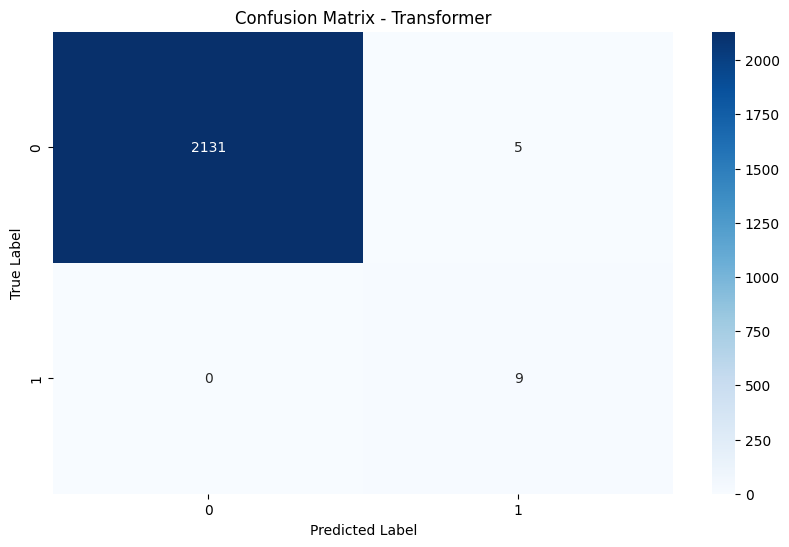

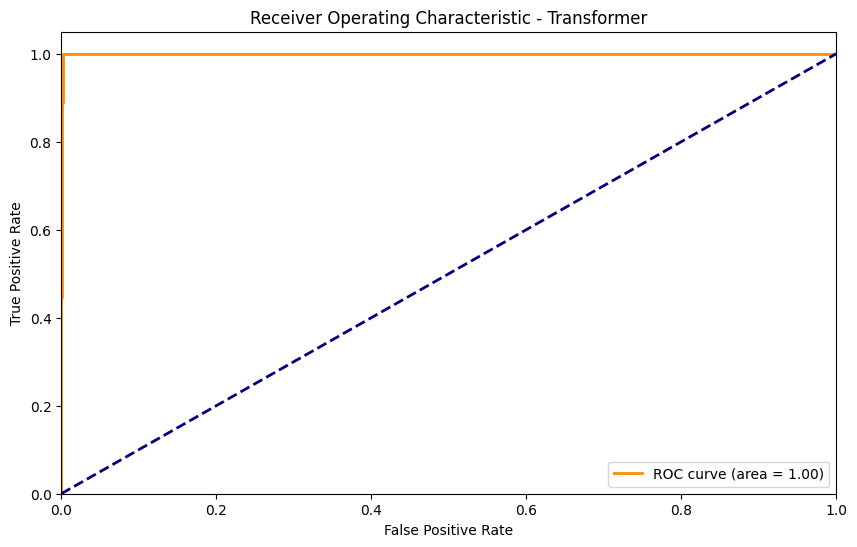

Inside train model with class weights
Epoch 1, Loss: 0.7246126276864246
Epoch 2, Loss: 0.5171083675866778
Epoch 3, Loss: 0.5006207855926319
Epoch 4, Loss: 0.44673619724132796
Epoch 5, Loss: 0.43641026453538373
Epoch 6, Loss: 0.428868177939545
Epoch 7, Loss: 0.38370792533863674
Epoch 8, Loss: 0.37923272597518837
Epoch 9, Loss: 0.39659319597889076
Epoch 10, Loss: 0.33815470354800875
Epoch 11, Loss: 0.3722173468294469
Epoch 12, Loss: 0.3242793418467045
Epoch 13, Loss: 0.3119481663134965
Epoch 14, Loss: 0.30037483327429404
Epoch 15, Loss: 0.31752266446975147
Epoch 16, Loss: 0.2842219217934392
Epoch 17, Loss: 0.29439252106980845
Epoch 18, Loss: 0.28462494342503225
Epoch 19, Loss: 0.28135857002978976
Epoch 20, Loss: 0.26566803895614366
Epoch 21, Loss: 0.2671363571320068
Epoch 22, Loss: 0.2566198443316601
Epoch 23, Loss: 0.2377944513308731
Epoch 24, Loss: 0.24652505285021933
Epoch 25, Loss: 0.24540436047721992
Epoch 26, Loss: 0.2541304176503962
Epoch 27, Loss: 0.23709537791596216
Epoch 28, Lo

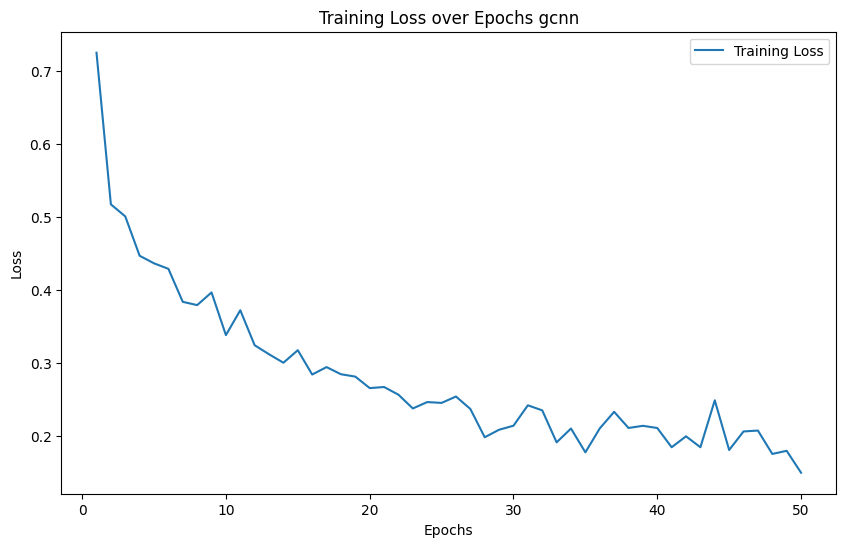

              precision    recall  f1-score   support

           0       1.00      0.97      0.99      2136
           1       0.11      0.78      0.19         9

    accuracy                           0.97      2145
   macro avg       0.55      0.88      0.59      2145
weighted avg       1.00      0.97      0.98      2145



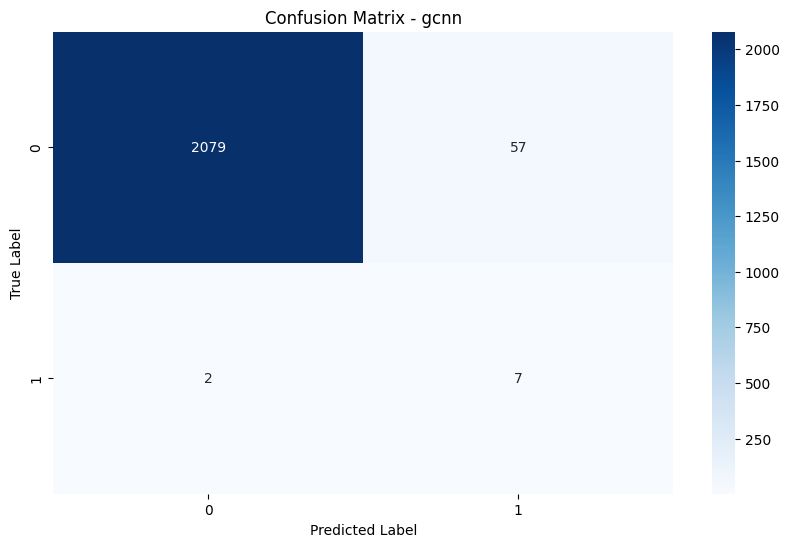

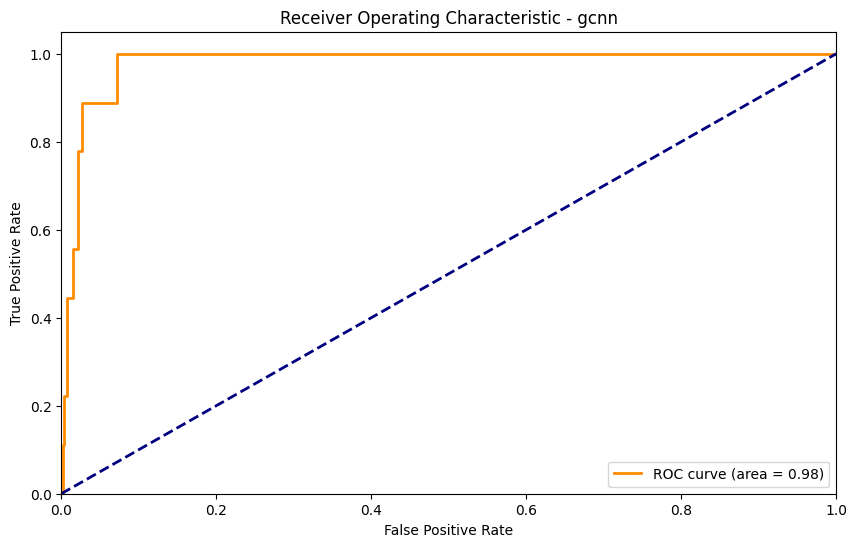

{'type10_label': {'GSageConv': 0.9918796992481203, 'GAT': 0.9732330827067669, 'GTransformer': 0.9930827067669173, 'GCNN': 0.9846616541353383}, 'type1_label_': {'GSageConv': 0.9987782529016493, 'GAT': 0.9987782529016493, 'GTransformer': 0.9987782529016493, 'GCNN': 0.998167379352474}, 'type2_label_': {'GSageConv': 0.9959718026183283, 'GAT': 0.9964753272910373, 'GTransformer': 0.9979859013091642, 'GCNN': 0.9818731117824774}, 'type3_label_': {'GSageConv': 0.9976689976689976, 'GAT': 0.9976689976689976, 'GTransformer': 0.9976689976689976, 'GCNN': 0.9724941724941725}}
type4_label_


100%|██████████| 1334/1334 [00:21<00:00, 61.25it/s]
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


train_data:933
test_data:401
Inside train model with class weights


RuntimeError: weight tensor should be defined either for all 2 classes or no classes but got weight tensor of shape: [1]

In [13]:
import random
from torch.utils.data import random_split


new_execution_flag = 1
# assign_value()
if new_execution_flag == 1:
    current_time = time.localtime()
    folder_name = time.strftime("%Y-%m-%d_%H-%M-%S", current_time)
else:
    folder_name = input("Input folder name from all_execution_data")

result_dict = {}
for file_path in xlsx_files:
    

    if new_execution_flag == 1:
        data = pd.read_excel(file_path)
        data['can_id'] = data['can_id'].astype(str)
    
    label_key = os.path.basename(file_path).split('.')[0][0:12]
    print(label_key)

    output_dir = f"all_execution_data/{folder_name}/{label_key}/graphs"
    visualization_dir = os.path.join(f"all_execution_data/{folder_name}/{label_key}", "visualizations")
    result_dir =  os.path.join(f"all_execution_data/{folder_name}/{label_key}", "results")

    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(visualization_dir, exist_ok=True)
    os.makedirs(result_dir, exist_ok=True)
    
    if new_execution_flag == 1:
        pyg_data_list = preprocess_data_density(data,output_dir,visualization_dir)
    else:
        pyg_data_list = load_saved_graphs(output_dir)

    # train_size = int(0.7 * len(pyg_data_list))
    # test_size = len(pyg_data_list) - train_size
    # train_data, test_data = random_split(pyg_data_list, [train_size, test_size])

    # print(f"train_data: {len(train_data)}\ntest_data: {len(test_data)}")


    train_size = int(0.7 * len(pyg_data_list))
    train_data = pyg_data_list[:train_size]
    test_data = pyg_data_list[train_size:]

    # # Assuming pyg_graphs is your dataset and you have split it into train and test
    # train_size = int(0.8 * len(pyg_graphs))
    # test_size = len(pyg_graphs) - train_size
    # train_dataset, test_dataset = torch.utils.data.random_split(pyg_graphs, [train_size, test_size])


    print(f"train_data:{len(train_data)}\ntest_data:{len(test_data)}")

    train_loader = DataLoader(train_data, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

    _,_,acc = run_SageConv(train_loader,test_loader,'SageConv',result_dir,visualization_dir)
    _,_,gat_acc = run_GAT(train_loader,test_loader,'GAT',result_dir,visualization_dir)
    _,_,transformer_acc = run_GTransformer(train_loader,test_loader,'Transformer',result_dir,visualization_dir)
    # _,_,sageConv_lstm_acc =run_SageConv_lstm(train_loader,test_loader,'sageConv_lstm',result_dir,visualization_dir)
    _,_,gcnn_acc =run_GCnn(train_loader,test_loader,'gcnn',result_dir,visualization_dir)

    result_dict[label_key] = {
        'GSageConv': acc,
        'GAT': gat_acc,
        'GTransformer': transformer_acc,
        # 'GSage_conv_lstm': sageConv_lstm_acc,
        'GCNN': gcnn_acc
    }

    print(result_dict)



# Create DataFrame
results_df = pd.DataFrame.from_dict(result_dict, orient='index')

# Save the DataFrame to a CSV file
time_str = str(time.time()).replace('.','_')
results_df.to_csv(f"all_execution_data/{folder_name}/results_analysis_{time_str}.csv")



In [ ]:
# result_dict

{'type10_label': {'GSageConv': 0.9077139837971117,
  'GAT': 0.8569918985558295,
  'GTransformer': 0.9115885875308207,
  'GCNN': 0.8555829517435717},
 'type1_label_': {'GSageConv': 0.9916617033948779,
  'GAT': 0.8862418106015485,
  'GTransformer': 0.9910661107802263,
  'GCNN': 0.8761167361524718},
 'type2_label_': {'GSageConv': 0.98545101842871,
  'GAT': 0.9835111542192047,
  'GTransformer': 0.9936954413191077,
  'GCNN': 0.989815712900097},
 'type3_label_': {'GSageConv': 0.9877222692633362,
  'GAT': 0.8289585097375106,
  'GTransformer': 0.9872988992379339,
  'GCNN': 0.8585944115156647},
 'type4_label_': {'GSageConv': 0.9961190168175937,
  'GAT': 0.9905131522207848,
  'GTransformer': 0.9952565761103924,
  'GCNN': 0.9909443725743855},
 'type5_label_': {'GSageConv': 0.8458265139116203,
  'GAT': 0.8497545008183306,
  'GTransformer': 0.8661211129296236,
  'GCNN': 0.8710310965630115},
 'type6_label_': {'GSageConv': 0.9190408357075024,
  'GAT': 0.7934472934472935,
  'GTransformer': 0.938271604

In [ ]:
results_df

,GSageConv,GAT,GTransformer,GCNN
type10_label,0.907714,0.856992,0.911589,0.855583
type1_label_,0.991662,0.886242,0.991066,0.876117
type2_label_,0.985451,0.983511,0.993695,0.989816
type3_label_,0.987722,0.828959,0.987299,0.858594
type4_label_,0.996119,0.990513,0.995257,0.990944
type5_label_,0.845827,0.849755,0.866121,0.871031
type6_label_,0.919041,0.793447,0.938272,0.880579
type7_label_,0.909677,0.762988,0.905263,0.848557
type8_label_,0.933549,0.916495,0.935019,0.889444
type9_label_,0.802011,0.697414,0.810920,0.772989


In [ ]:

# Create DataFrame
results_df = pd.DataFrame.from_dict(result_dict, orient='index')

# Save the DataFrame to a CSV file
time_str = str(time.time()).replace('.','_')
results_df.to_csv(f"all_execution_data/{folder_name}/results_analysis_{time_str}.csv")

In [ ]:
results_df